In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [2]:
#parameters for visualization
opts={'size':14, 'node_border':False, 'node_size':200, 'font_size':9, 'vertex_alpha':0.6,'title_key':'id'}

from eden.util.display import draw_graph, serialize_graph
import itertools
def plot(graphs, num=3, file_name=None, opts=None):    
    graphs = itertools.islice(graphs,num)
    for i,graph in enumerate(graphs): 
        if file_name is not None:
            draw_graph(graph, file_name=file_name+str(i)+'.png', **opts)
        else:
            draw_graph(graph, **opts)

In [3]:
#code for making artificial dataset
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGU', motives=None, motif_length=6, sequence_length=100, n_sequences=1000, n_motives=1, p=0.2):
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
        
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences / n_motives

    counter=0
    seqs=[]
    for i in range(n_seq_per_motif):
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            seqs.append(('>ID%d'%counter,seq))
            counter += 1
    return motives, seqs

---

In [4]:
#setup parameters
alphabet='ACGU'
motif_length=10
motives=['A'*motif_length,'C'*motif_length,'G'*motif_length,'U'*motif_length]
sequence_length=80
n_sequences=300
p=0.01

#make dataset
MAKE_RANDOM_MOTIVES=False
if MAKE_RANDOM_MOTIVES:
    motives, seqs = make_artificial_dataset(alphabet=alphabet,motives=None, n_motives=4, motif_length=motif_length, sequence_length=sequence_length,n_sequences=n_sequences,p=p)
else:
    motives, seqs = make_artificial_dataset(alphabet=alphabet,motives=motives, sequence_length=sequence_length,n_sequences=n_sequences,p=p)
    
for motif in motives:
    print motif
    
for h, seq in seqs[:10]:
    print h
    print seq
print '...'
print '%d sequences' % len(seqs)

AAAAAAAAAA
CCCCCCCCCC
GGGGGGGGGG
UUUUUUUUUU
>ID0
GUGUCCCAUAGUUUAGCAAUUGCGACCGUAACGACAAAAAAAAAACUUAAGAACUCGCAUUUAGAGAUUACCCACUAGAG
>ID1
UCACUCUUCGAGCAUAAGUAAUCAAGCGUAACCUGCCCCCCCCCCCUUCUCCGUGAAAGGGUGUUUAAGGUGAACGCAGC
>ID2
UAUUUCGUCCUGCUUUAUUACAUGCCUGAAGCGUCGGGGGGGGGGGCUGUCGAUCCGGCACCCGGUCAAAGUUGACGCGG
>ID3
GCCCUGCUUCGCCACGUCCGCCAGAGGUCAAUCUCUUUUUAUUUUCGAGCUAUUCCCAGUCAUAUUCCGUUAAACCACUC
>ID4
UAUAUAUCCGUGUGCUCCAGACUUCACUGAGAACUAAAAAAAAAAAGAUUCACACUUGAGUGUUCGUCACGUCUUAAAGA
>ID5
AGCUCAAGAUGCCGAGGAAGGAGGCGUCUAUGCUGCCCCCCCCCCUGGAUGGCUAGCUAAGGCGGGAUACCCUAACGCCU
>ID6
AAAGUGGCGUGGCUAAUUCCGGCCAGCCUCAAGCUGGGGGGGGGGAGCUUCGUAUCGUGGCCUAAAUUUGGAUCACCUAA
>ID7
GCUCGCCAUCGGCGGCUCCAUAUUUGCUUUCUACUUUUUUUUUUUGUUUAAACGCCUGCGUUCCAAUGGAAGGGCUGAGA
>ID8
UUAGUCGAACCAGUUCGUAAGUCGAAAAAUUUGUAAAAAAAAAAAUGAUUAUAAAUAAUGUGUAUAUGGGACGGGUUCUG
>ID9
AUUCAUUUUCUUUGGUAUAAGUUGAAAUAACGACACCCCCCCCCCGUUGAGAUCUUGAACAUAUAGUCCCUGAGCAAUUC
...
300 sequences


In [18]:
from GArDen.transform.rna_structure import PathGraphToRNAPlfold
p2g_plfold = PathGraphToRNAPlfold( max_num_edges=1, window_size=150, max_bp_span=30, avg_bp_prob_cutoff=0.6, no_lonely_bps=True, nesting=False)
graphs = p2g_plfold.transform(graphs)

In [ ]:
from itertools import islice
from eden.util.display import draw_graph_set
draw_graph_set(islice(graphs,16),n_graphs_per_line=4, size=20, title_key='id', prog='neato', node_border=1, node_size=600, colormap='rainbow',
               edge_color='_label_',edge_alpha=.4, secondary_vertex_label='weight',vertex_label='label', vertex_color='weight', ignore_for_layout='nesting')

---

In [ ]:
#identify motif region
start_1 = (sequence_length - motif_length)/2
end_1 = start_1 + motif_length
weight_1 = 30

context=20
#make a context zone
start_2 = start_1 - context
end_2 = end_1 + context
weight_2 = weight_1 / 4

background_weight=1

start_end_weight_list = [(-1,-1,background_weight),(start_2,end_2,weight_2),(start_1,end_1,weight_1)]
listof_start_end_weight_list = [start_end_weight_list]*len(seqs)

In [ ]:
from GArDen.convert.sequence import SeqToPathGraph
f2g = SeqToPathGraph()
graphs = f2g.transform(seqs)

In [ ]:
from GArDen.transform.rna_structure import PathGraphToRNAFold
p2g_fold = PathGraphToRNAFold()
graphs = p2g_fold.transform(graphs)

In [ ]:
from GArDen.transform.node import WeightWithIntervals
wwi = WeightWithIntervals()
graphs = wwi.transform(graphs, start_end_weight_list=start_end_weight_list)

In [ ]:
from GArDen.transform.rna_annotation import AnnotateSecondaryStructureElements
asse = AnnotateSecondaryStructureElements()
graphs = asse.transform(graphs)

In [ ]:
from GArDen.transform.contraction import Minor, contraction_modifier
#reduce all 'label' attributes of contracted nodes to a histogram to be written in the 'label' attribute of the resulting graph 
label_modifier = contraction_modifier(attribute_in='part_name', attribute_out='label', reduction='set_categorical')
#reduce all 'weight' attributes of contracted nodes using a sum to be written in the 'weight' attribute of the resulting graph 
weight_modifier = contraction_modifier(attribute_in='weight', attribute_out='weight', reduction='average')
modifiers = [label_modifier, weight_modifier]

m = Minor()
graphs = m.transform(graphs, minorization_attribute='part_id', nesting=True, modifiers=modifiers, minorization_weight_scaling_factor=2)

In [56]:
from GArDen.transform.node import ReweightDictionary
rd = ReweightDictionary()
weight_dict = {'label':{'s':1, 'm':10, 'h':5, 'i':2}}
graphs = rd.transform(graphs, weight_dict=weight_dict)

In [57]:
%%time
graphs = list(graphs)

CPU times: user 1.98 s, sys: 1.08 s, total: 3.05 s
Wall time: 6.56 s


In [ ]:
from sklearn.cluster import DBSCAN
clusterer = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, p=None, random_state=None)

In [ ]:
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=40, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=1, copy_x=True, n_jobs=-1)

In [65]:
from sklearn.cluster import SpectralClustering
clusterer = SpectralClustering(n_clusters=50, eigen_solver=None, random_state=None, n_init=10, gamma=1.0, affinity='rbf', n_neighbors=5, eigen_tol=0.0, assign_labels='kmeans', degree=3, coef0=1, kernel_params=None)

In [66]:
%%time
from GArDen.interfaces import partition
parameters_priors={'r':[3],'d':[3], 'n_jobs':[-1]}
partition_list = partition(graphs, program=clusterer, parameters_priors=parameters_priors)

CPU times: user 6.52 s, sys: 925 ms, total: 7.44 s
Wall time: 11.5 s


In [67]:
min_clust_size = 5
max_clust_size = 20
for cluster_id in partition_list:
    clust_size=len(partition_list[cluster_id])
    if clust_size > min_clust_size and clust_size < max_clust_size:
        print 'cluster id: %d size:%d' % (cluster_id, clust_size )

cluster id: 0 size:11
cluster id: 1 size:17
cluster id: 3 size:13
cluster id: 8 size:6
cluster id: 9 size:9
cluster id: 10 size:7
cluster id: 11 size:6
cluster id: 12 size:6
cluster id: 16 size:9
cluster id: 17 size:12
cluster id: 19 size:6
cluster id: 20 size:6
cluster id: 21 size:6
cluster id: 22 size:7
cluster id: 27 size:7
cluster id: 30 size:7
cluster id: 32 size:6
cluster id: 34 size:6
cluster id: 35 size:6
cluster id: 36 size:9
cluster id: 43 size:7
cluster id: 44 size:9
cluster id: 49 size:9


--------------------------------------------------------------------------------
cluster:0 size:11


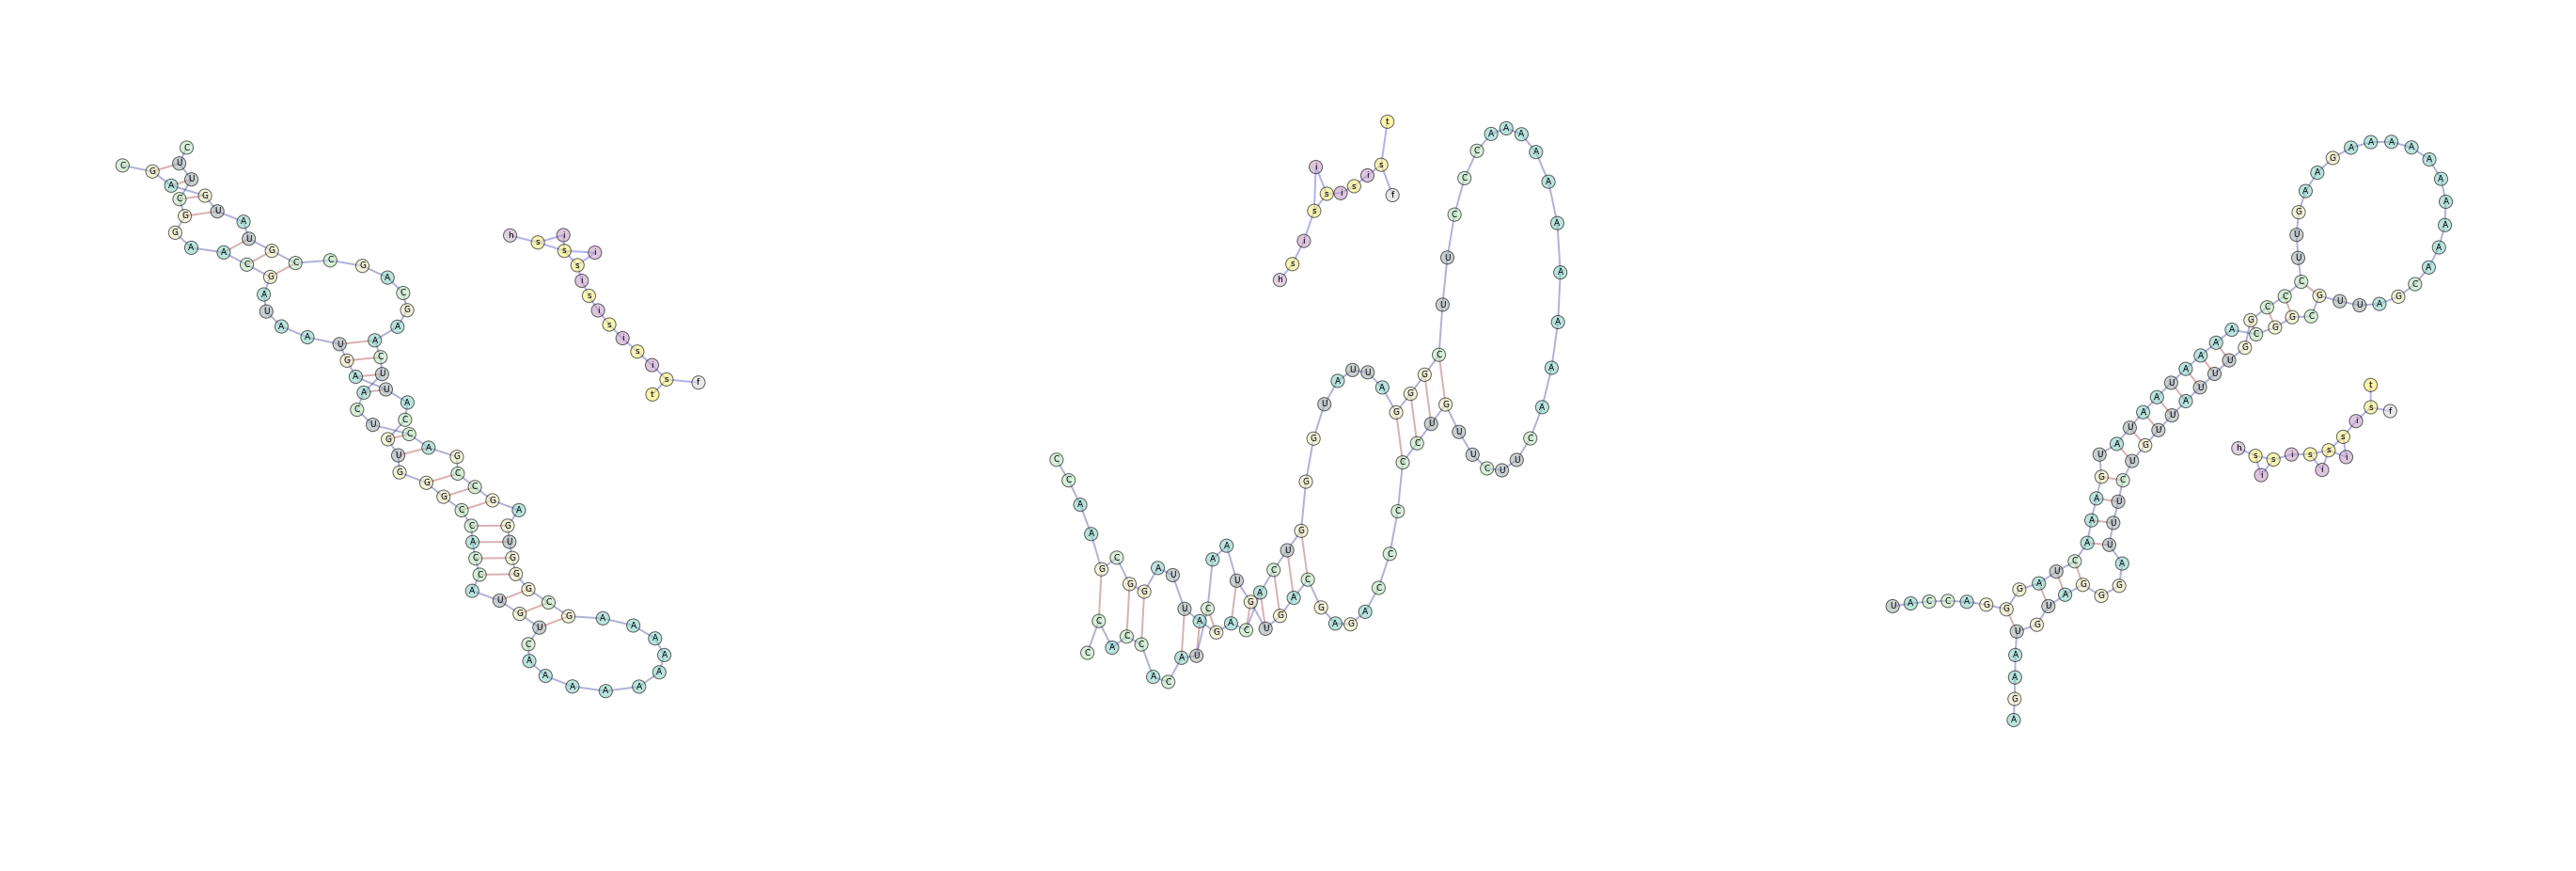

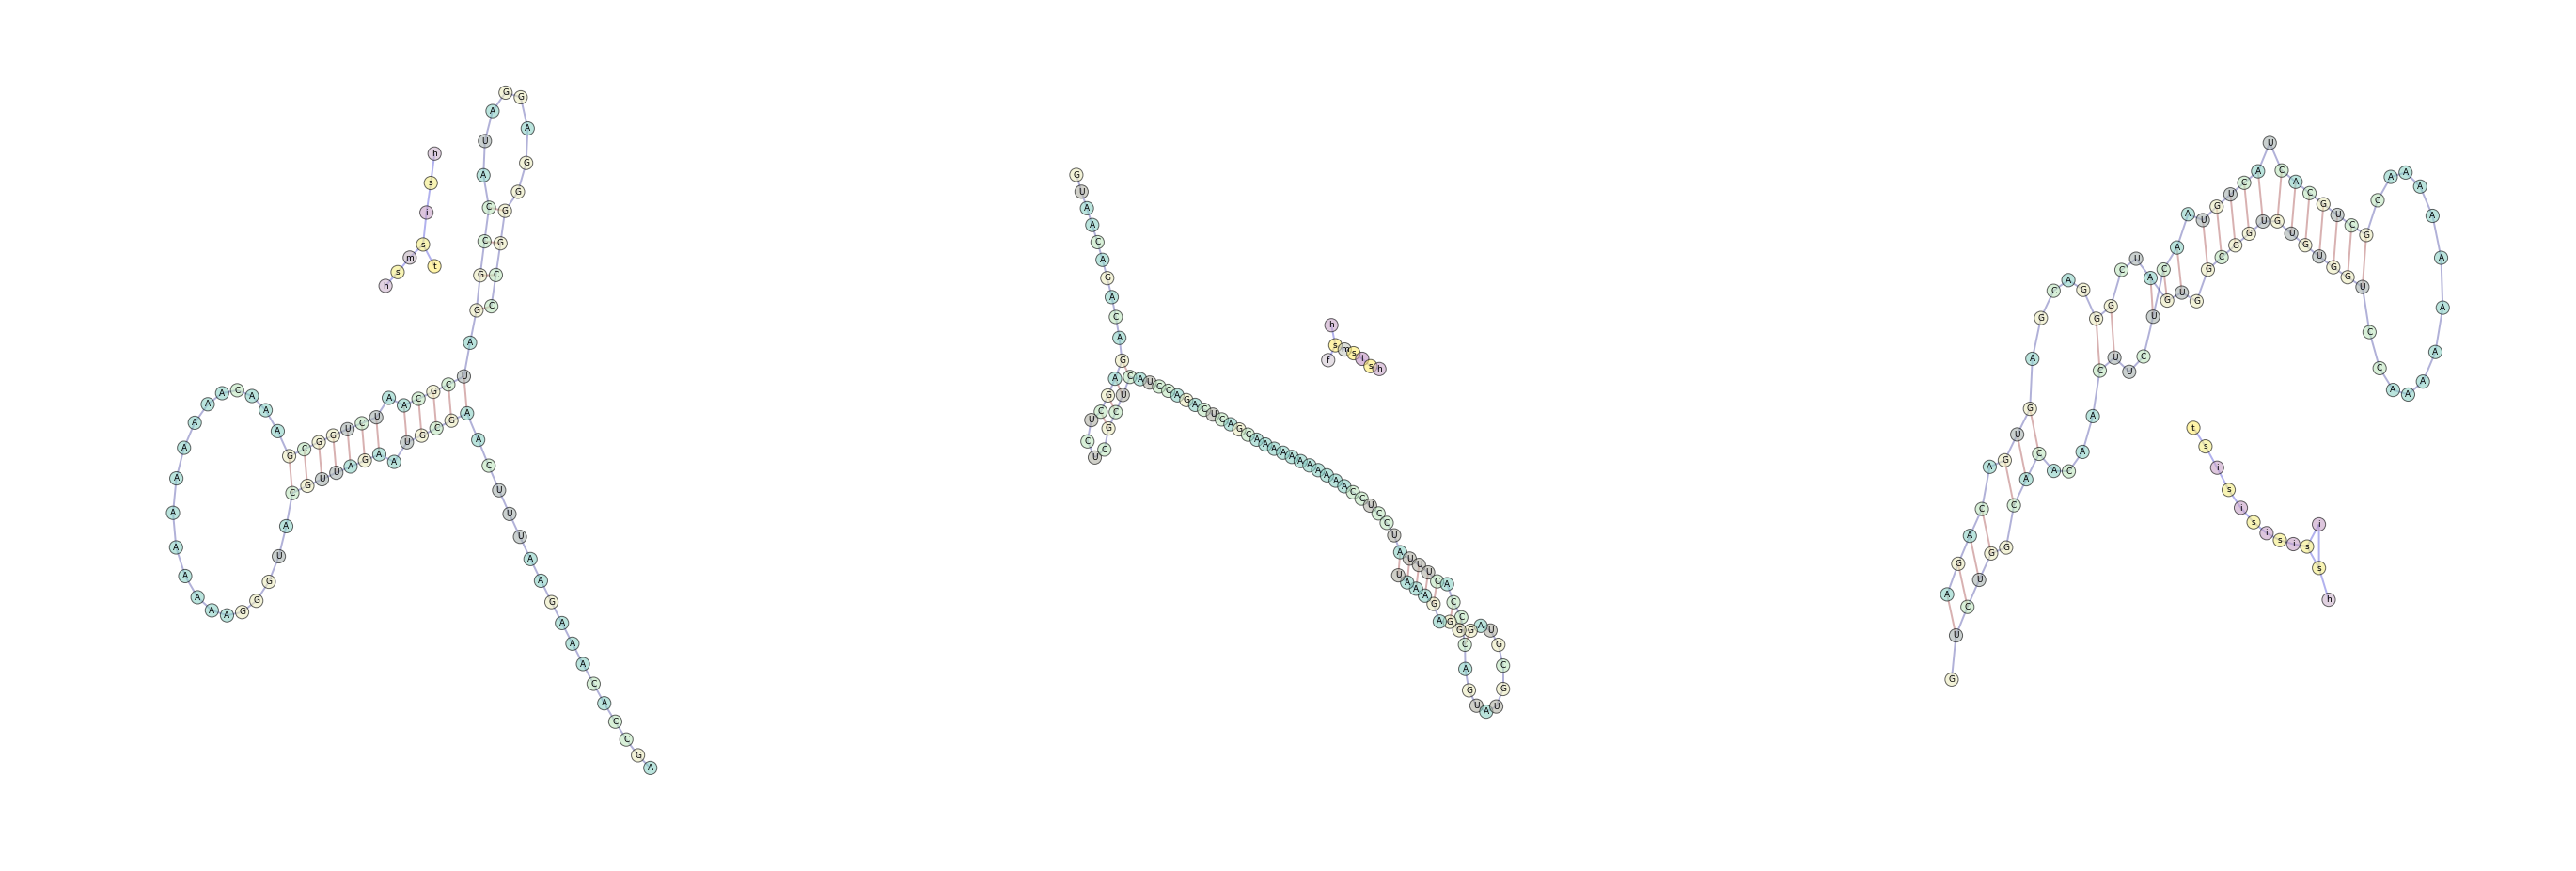

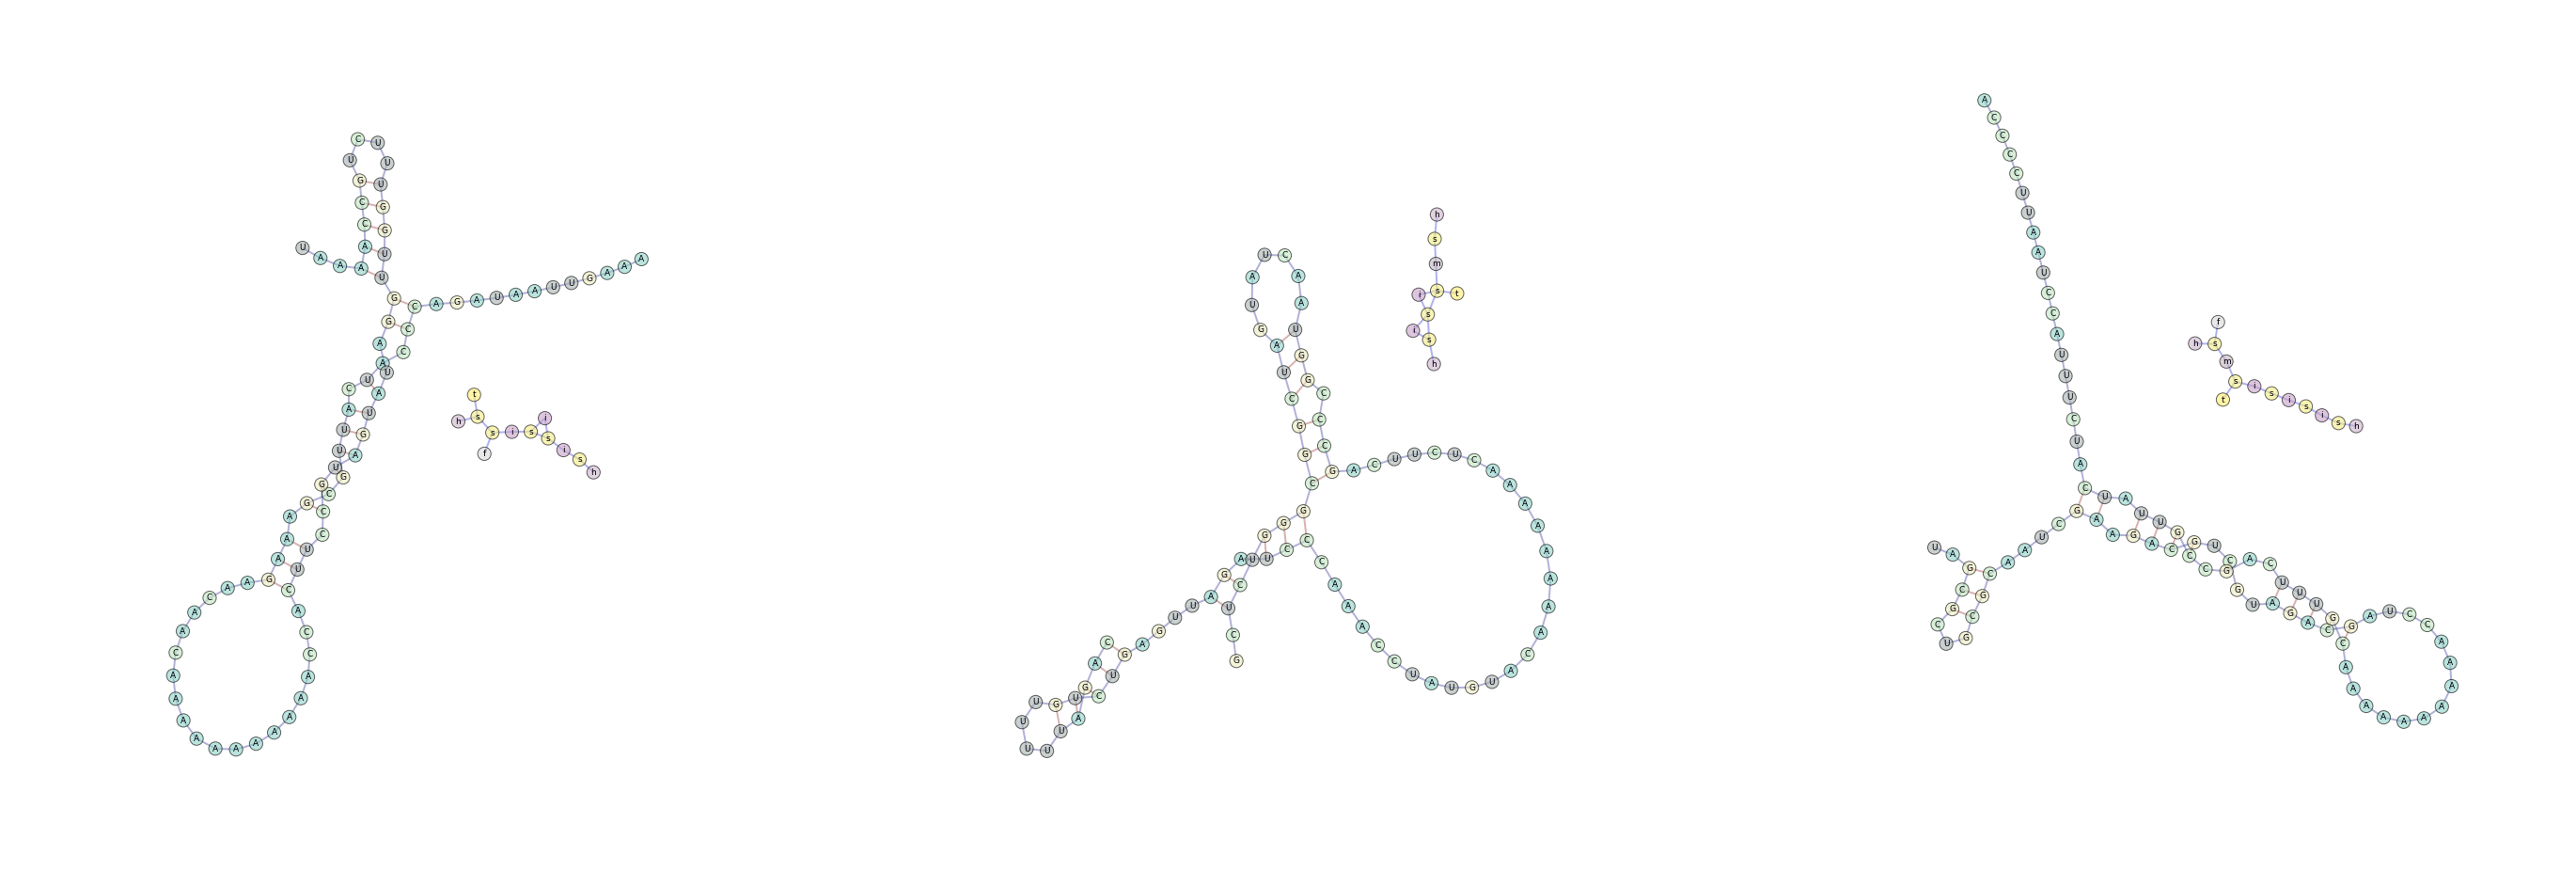

--------------------------------------------------------------------------------
cluster:1 size:17


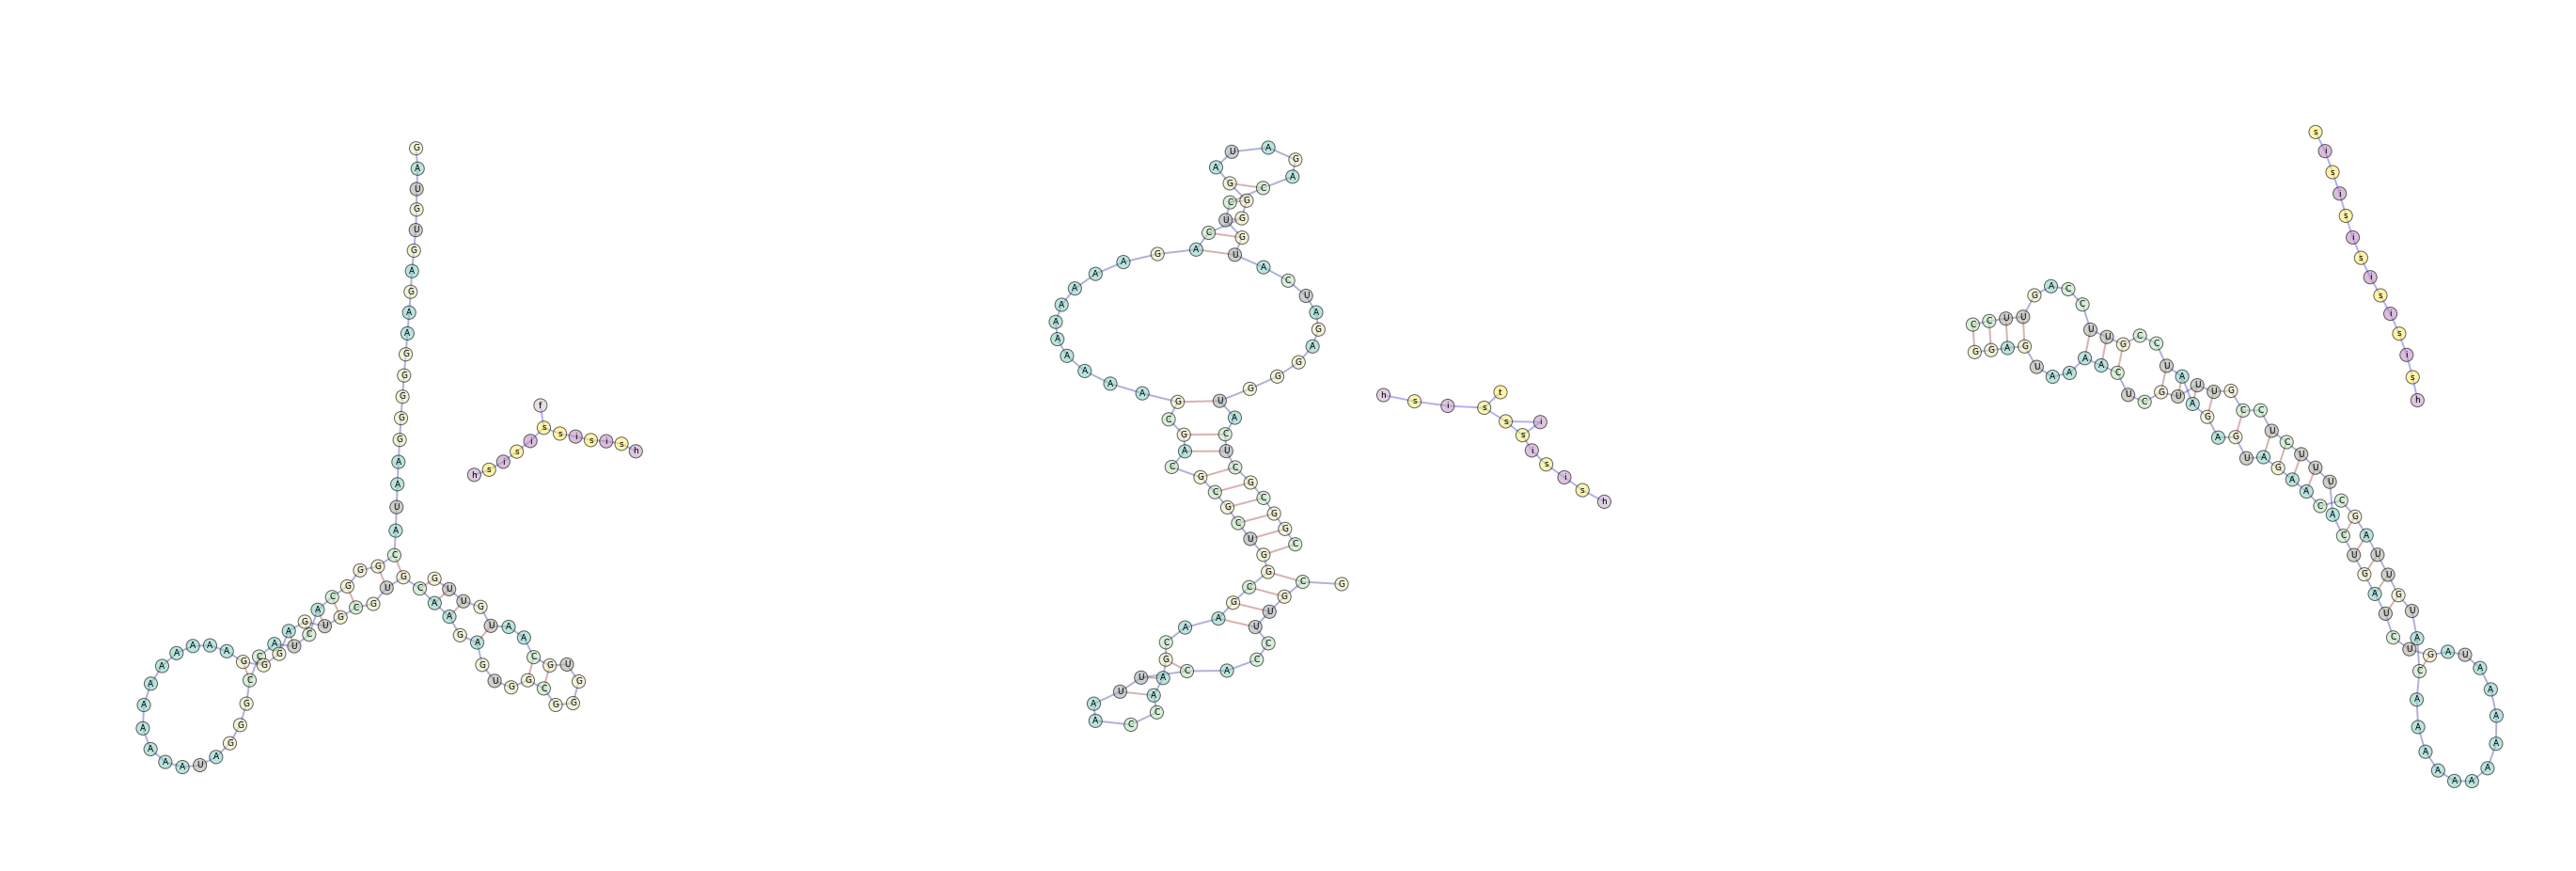

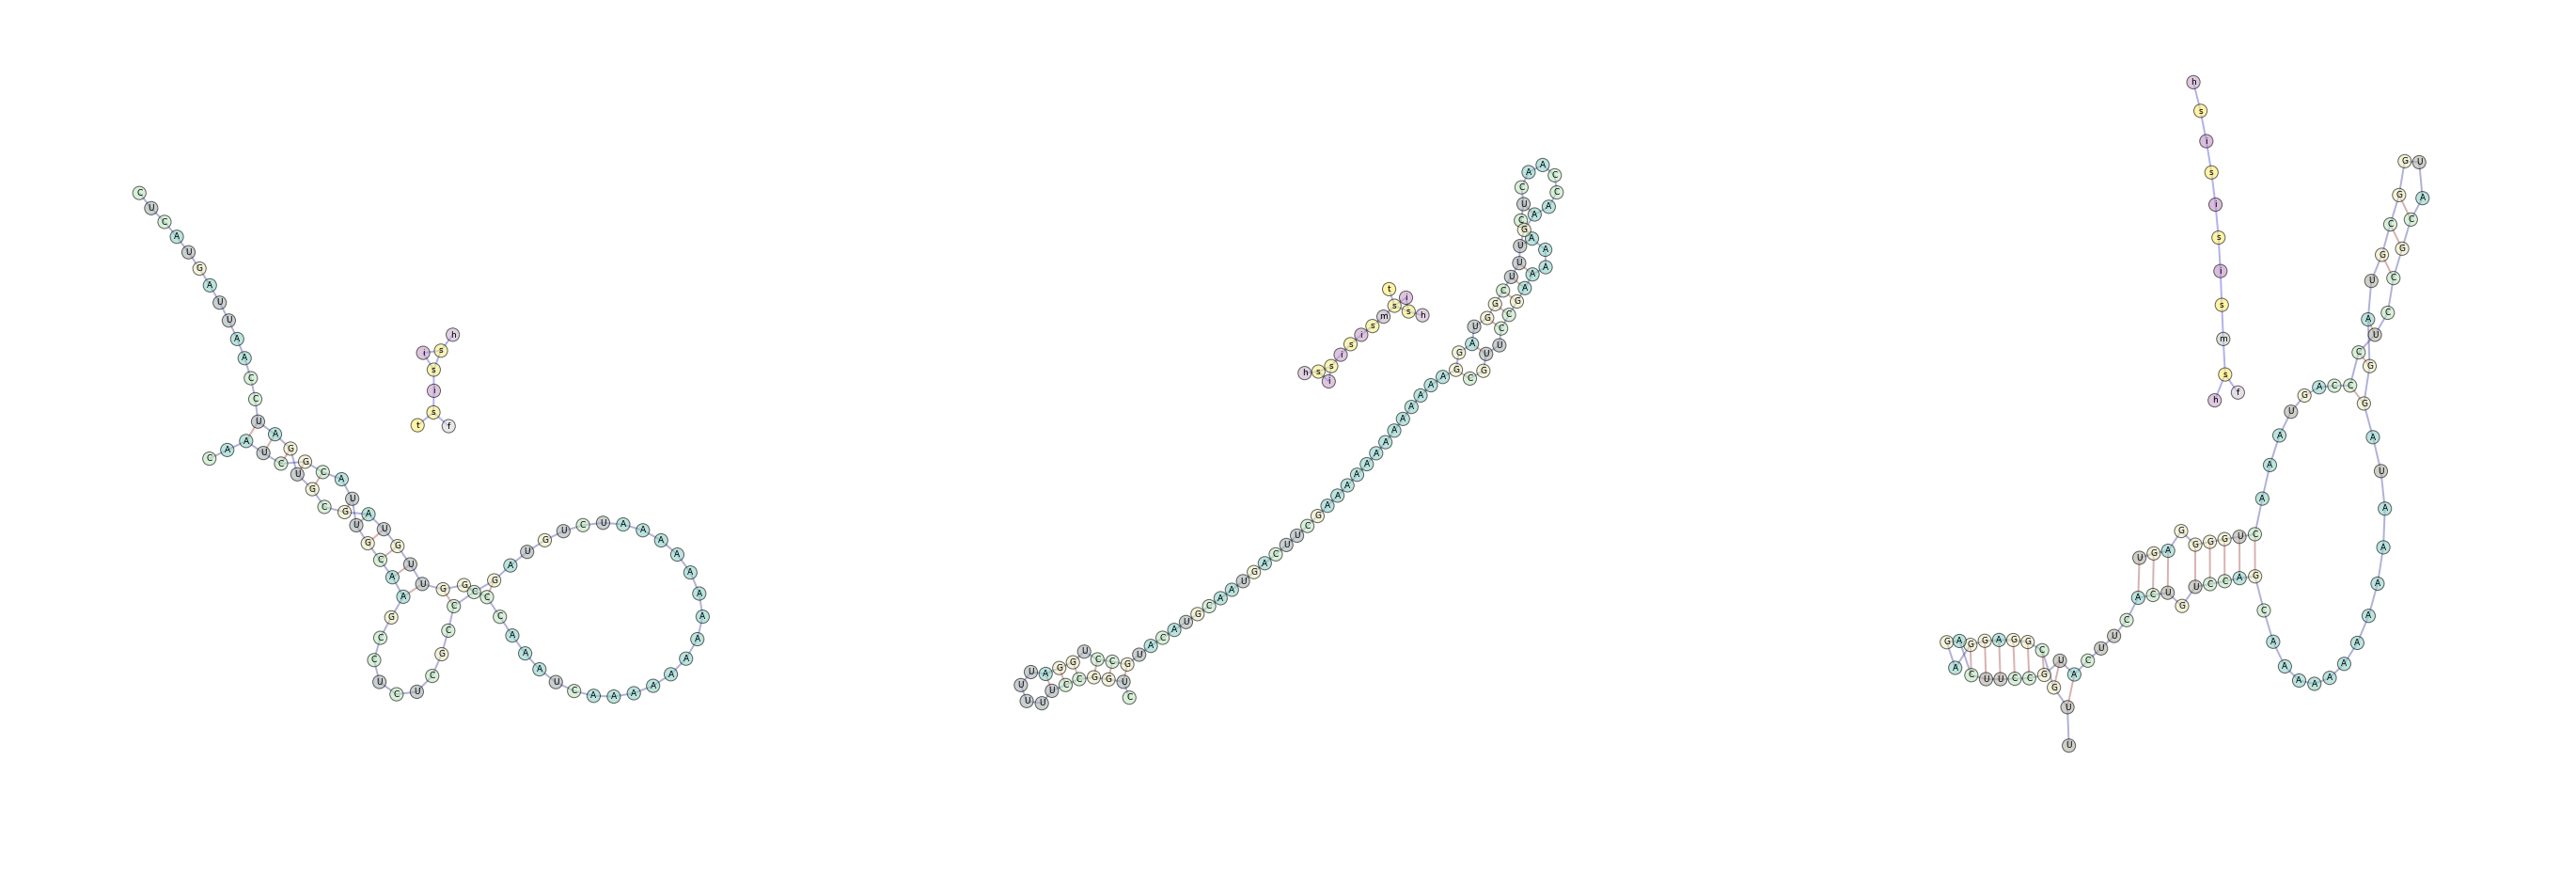

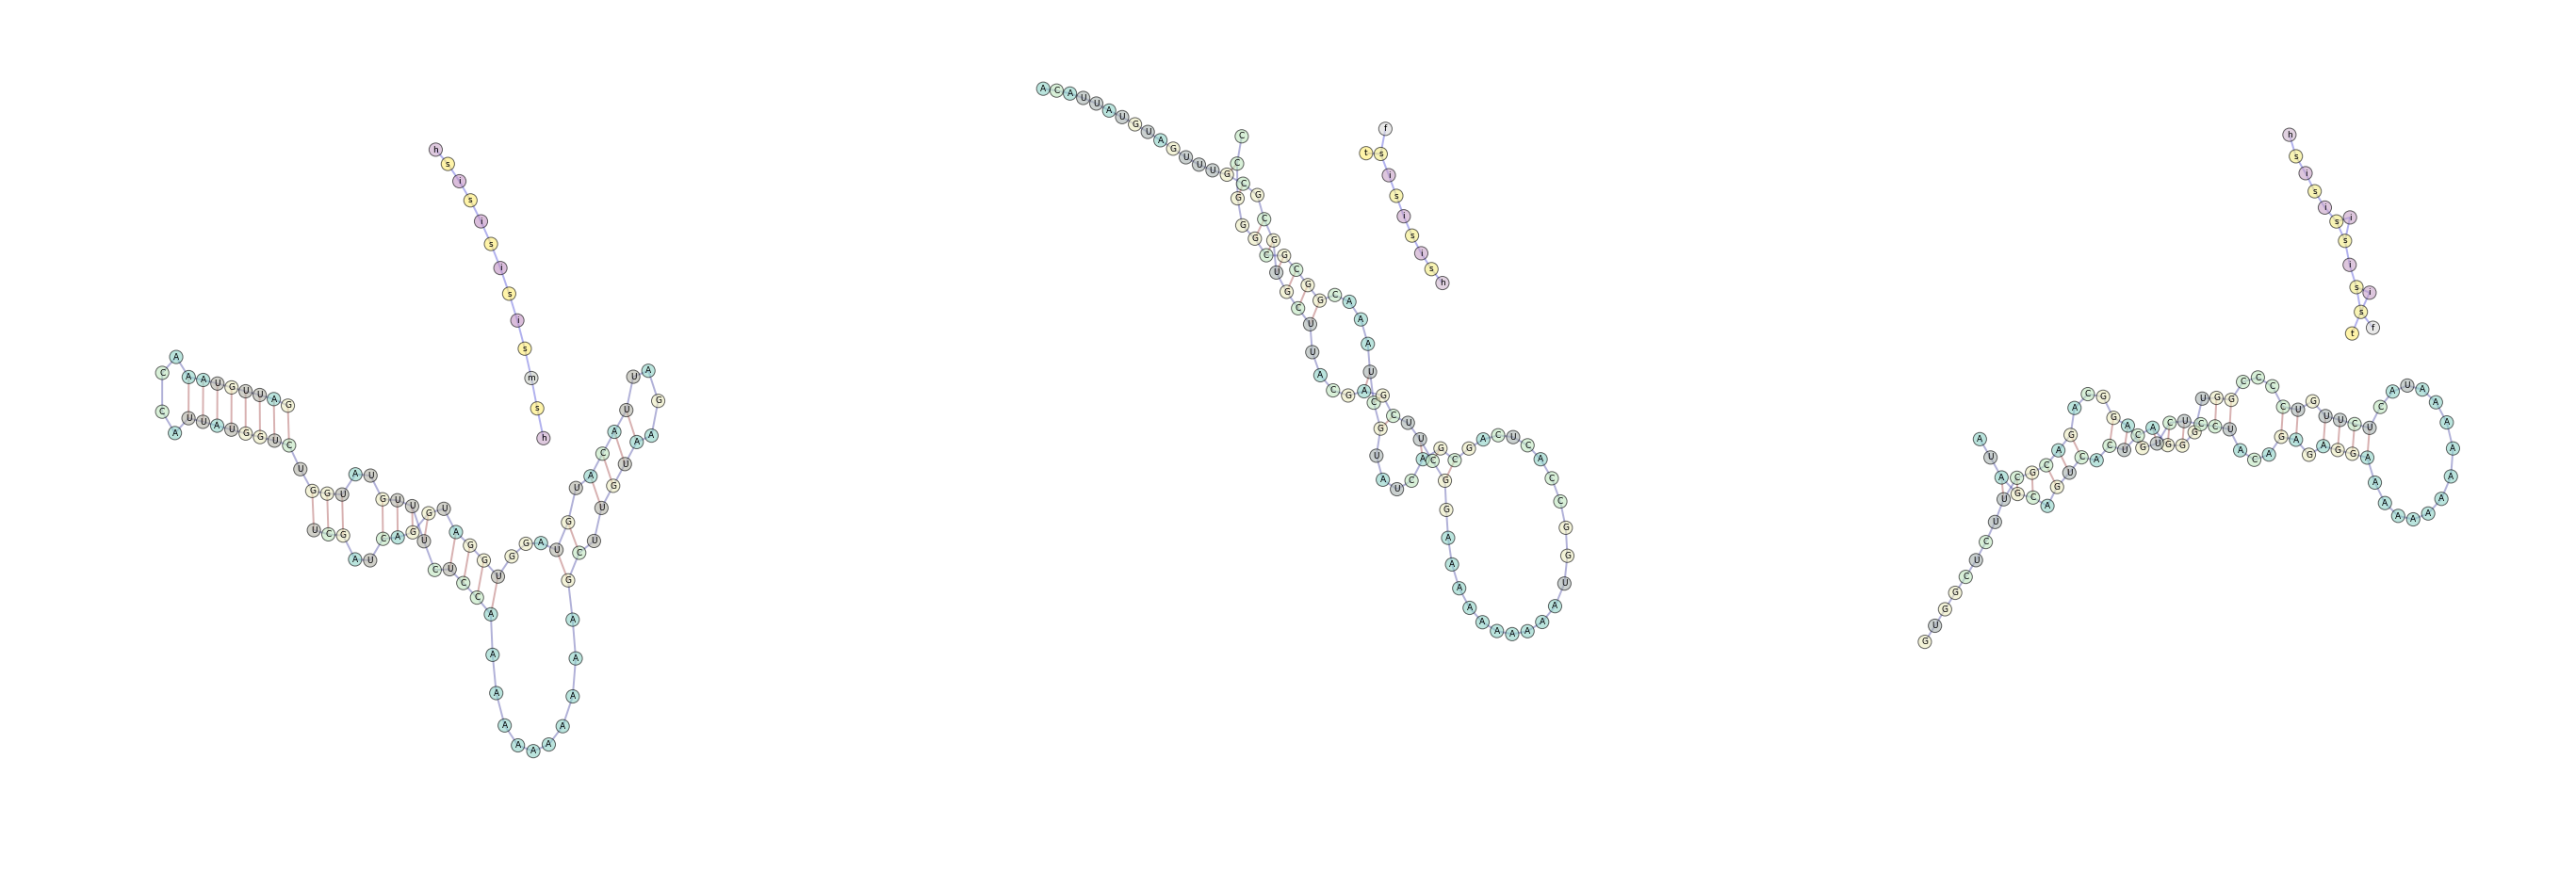

--------------------------------------------------------------------------------
cluster:3 size:13


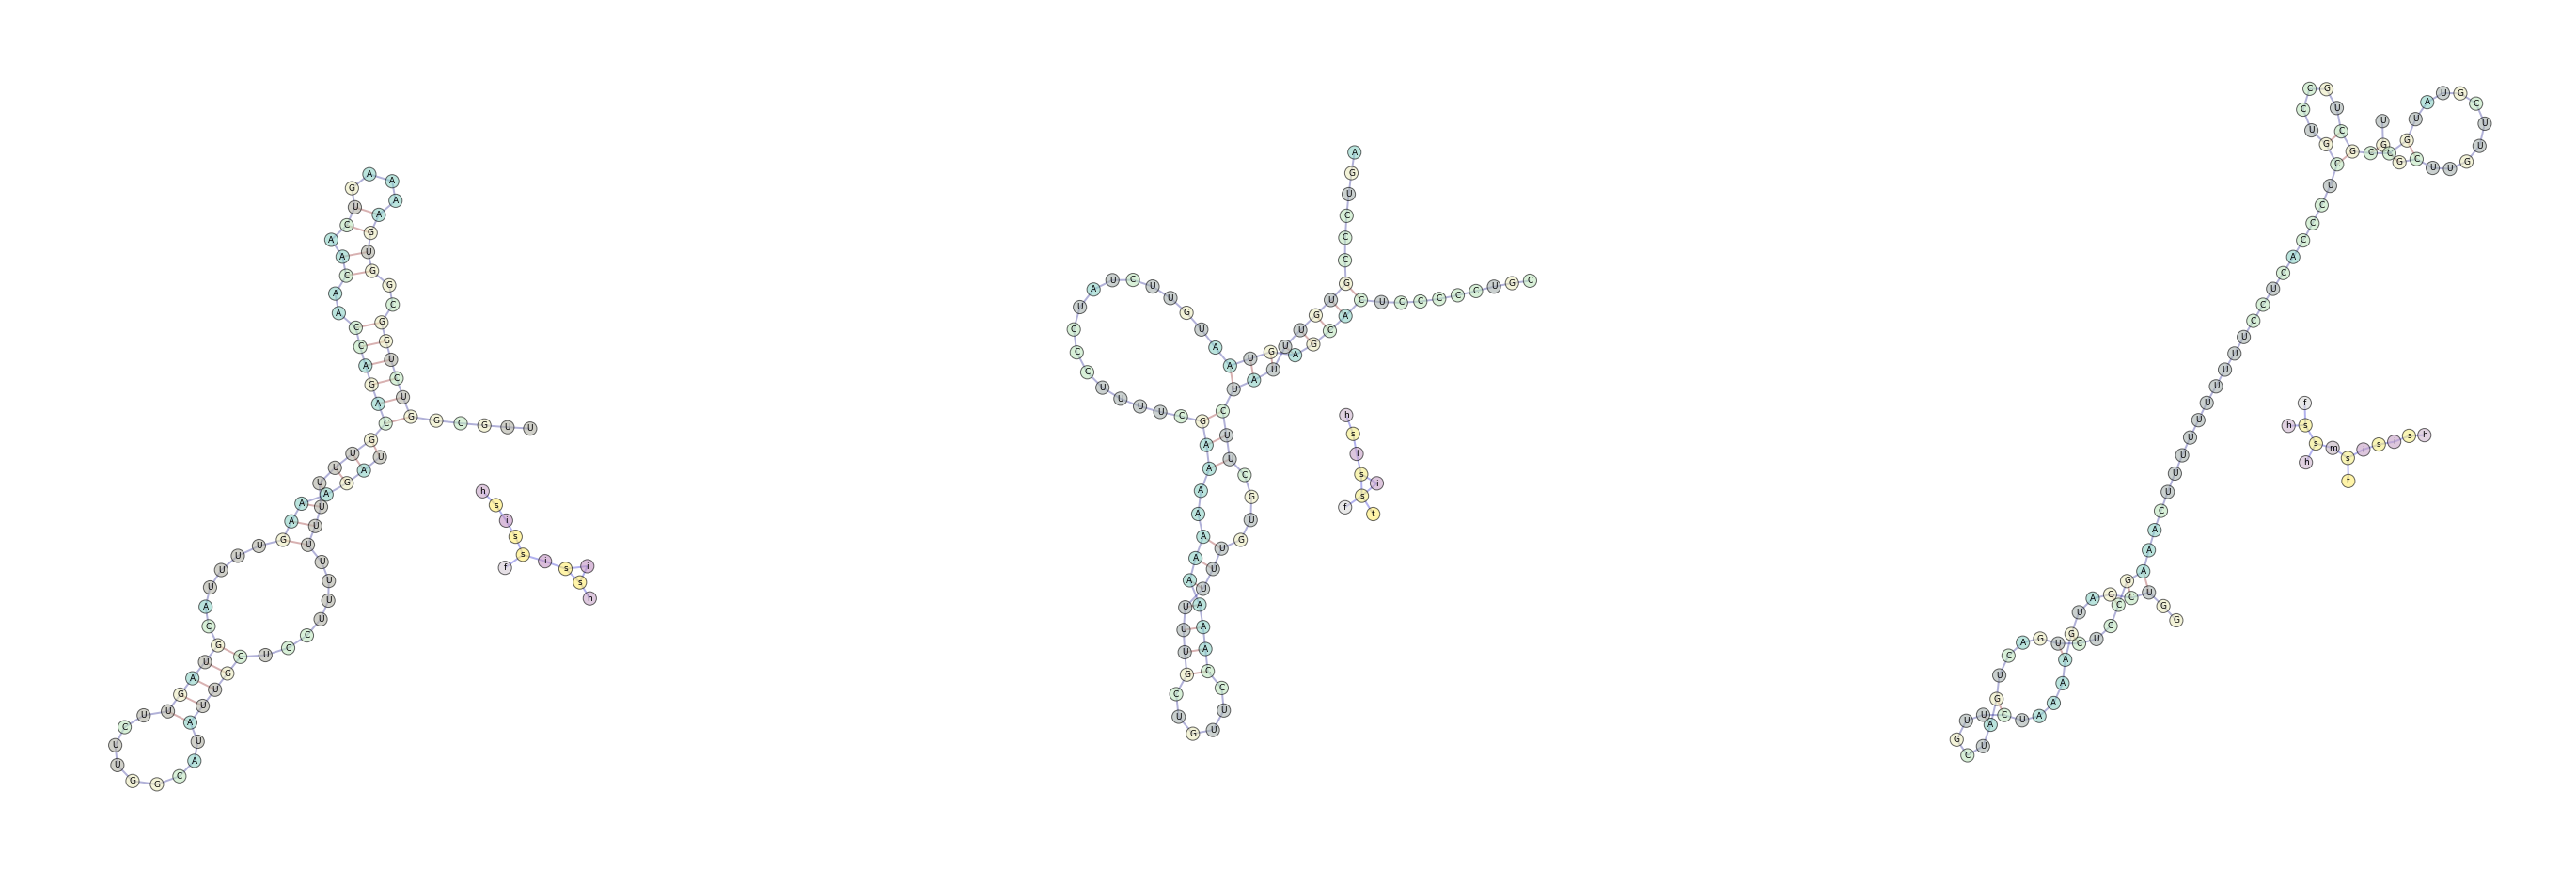

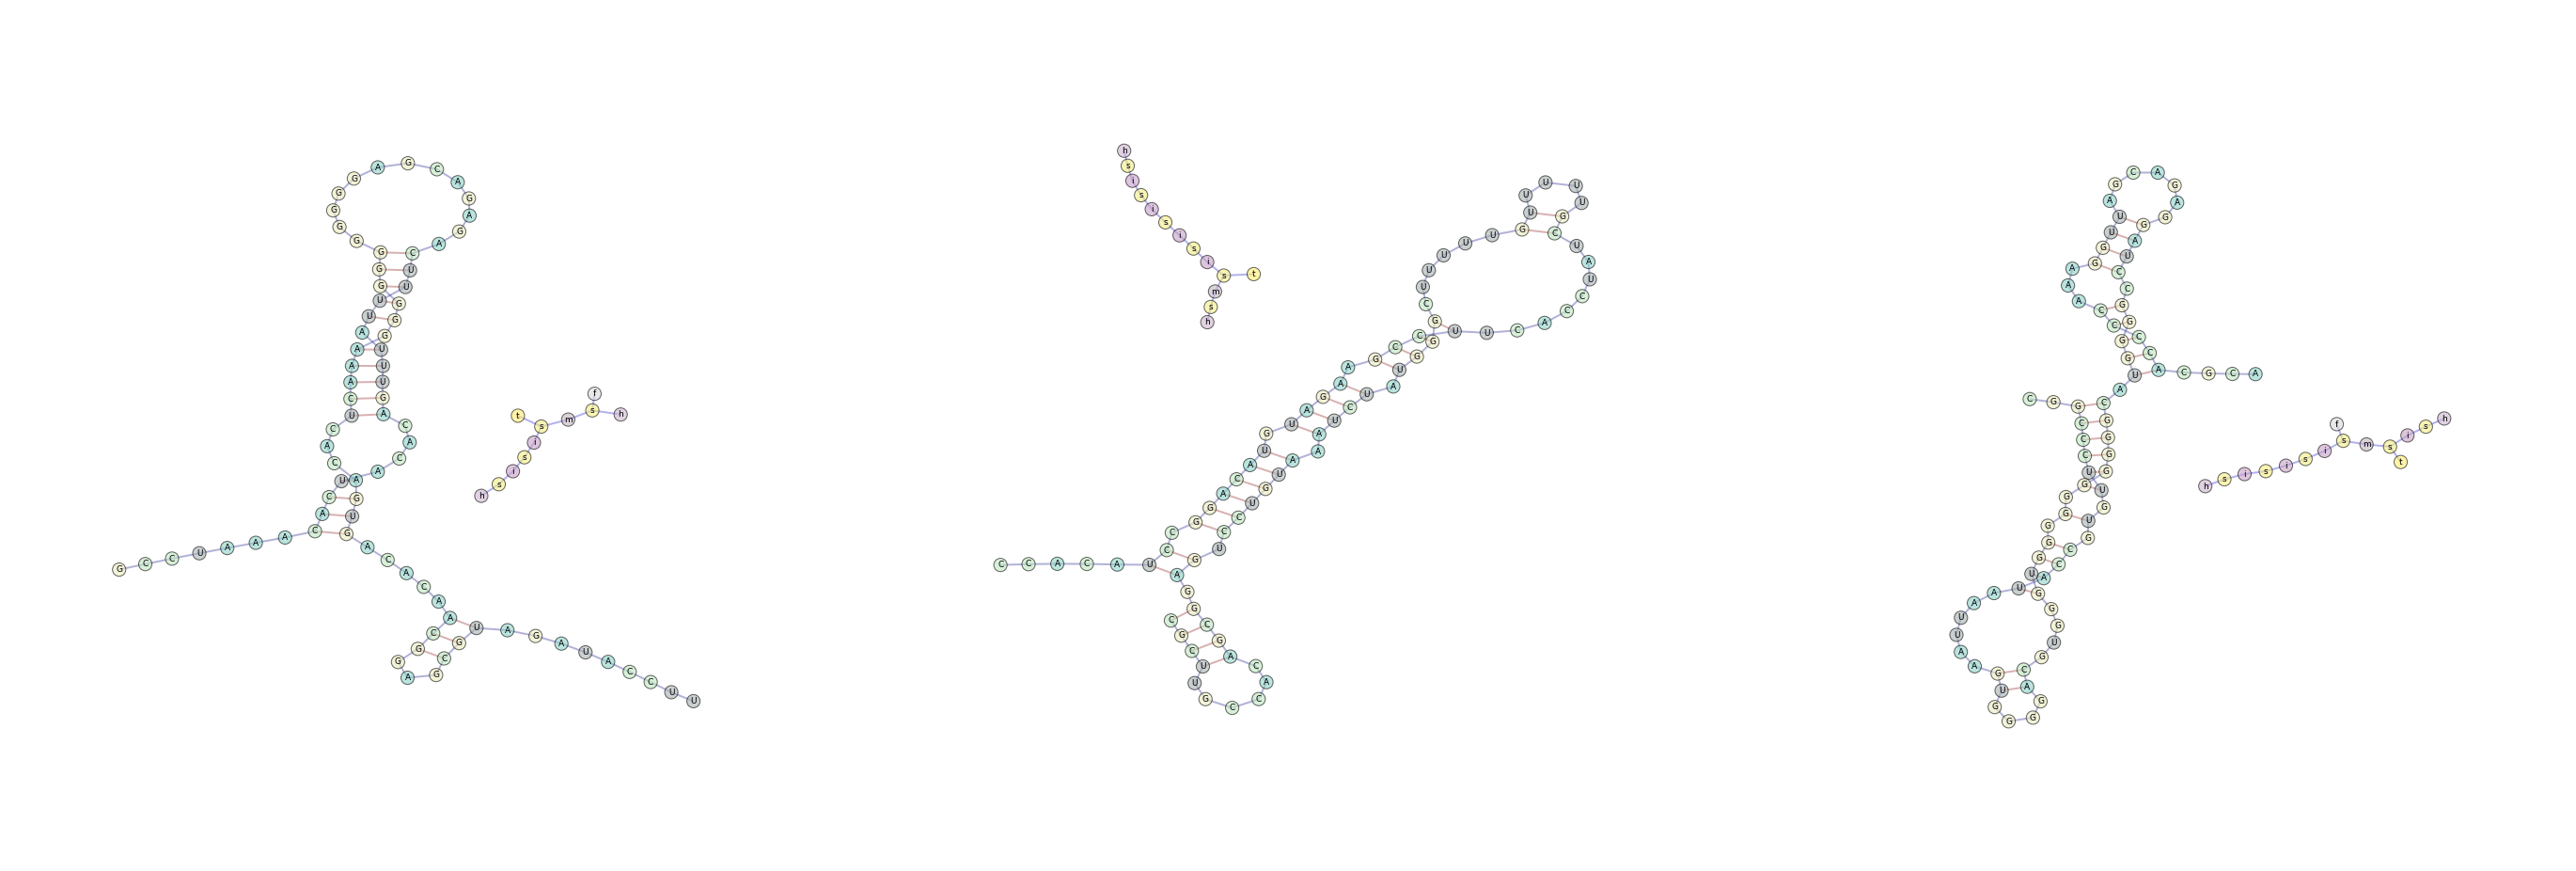

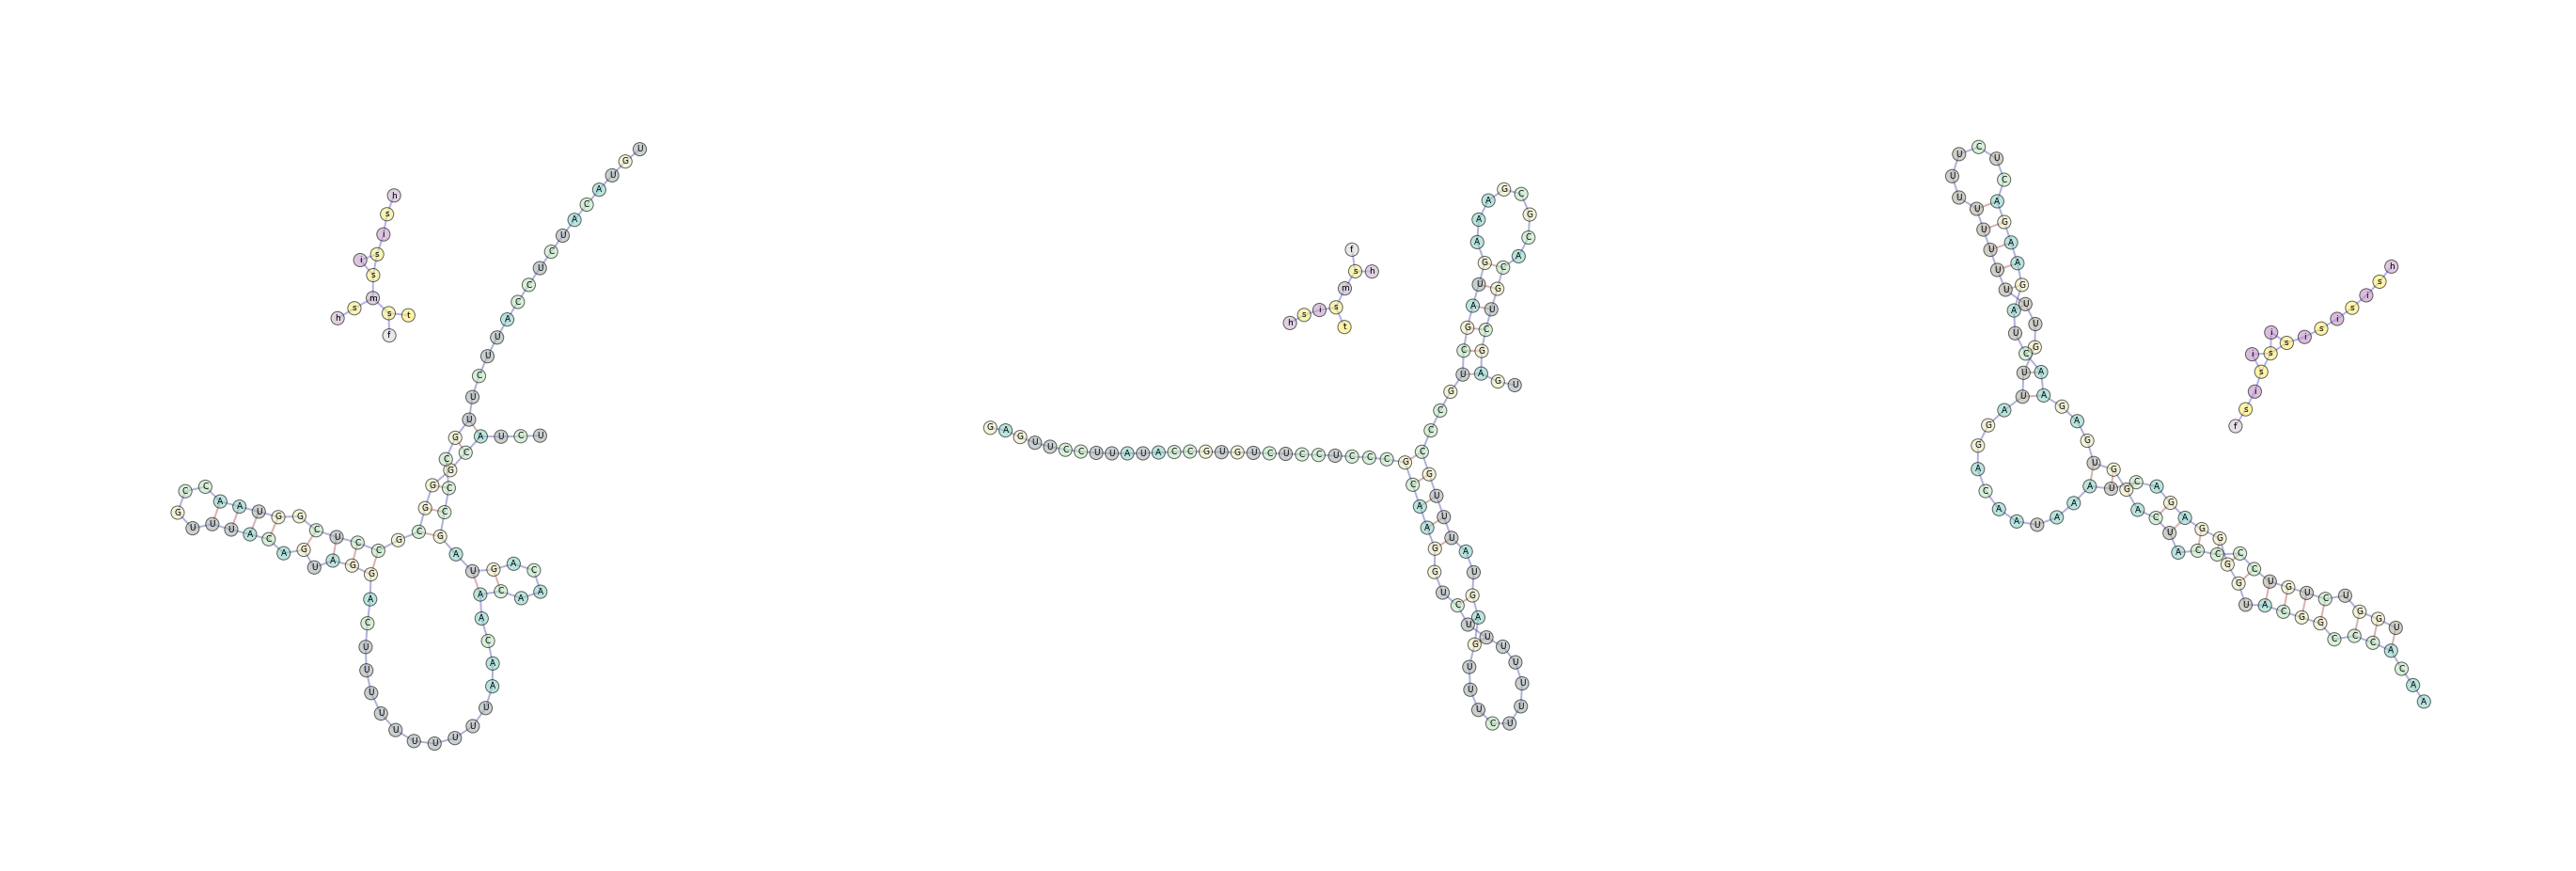

--------------------------------------------------------------------------------
cluster:8 size:6


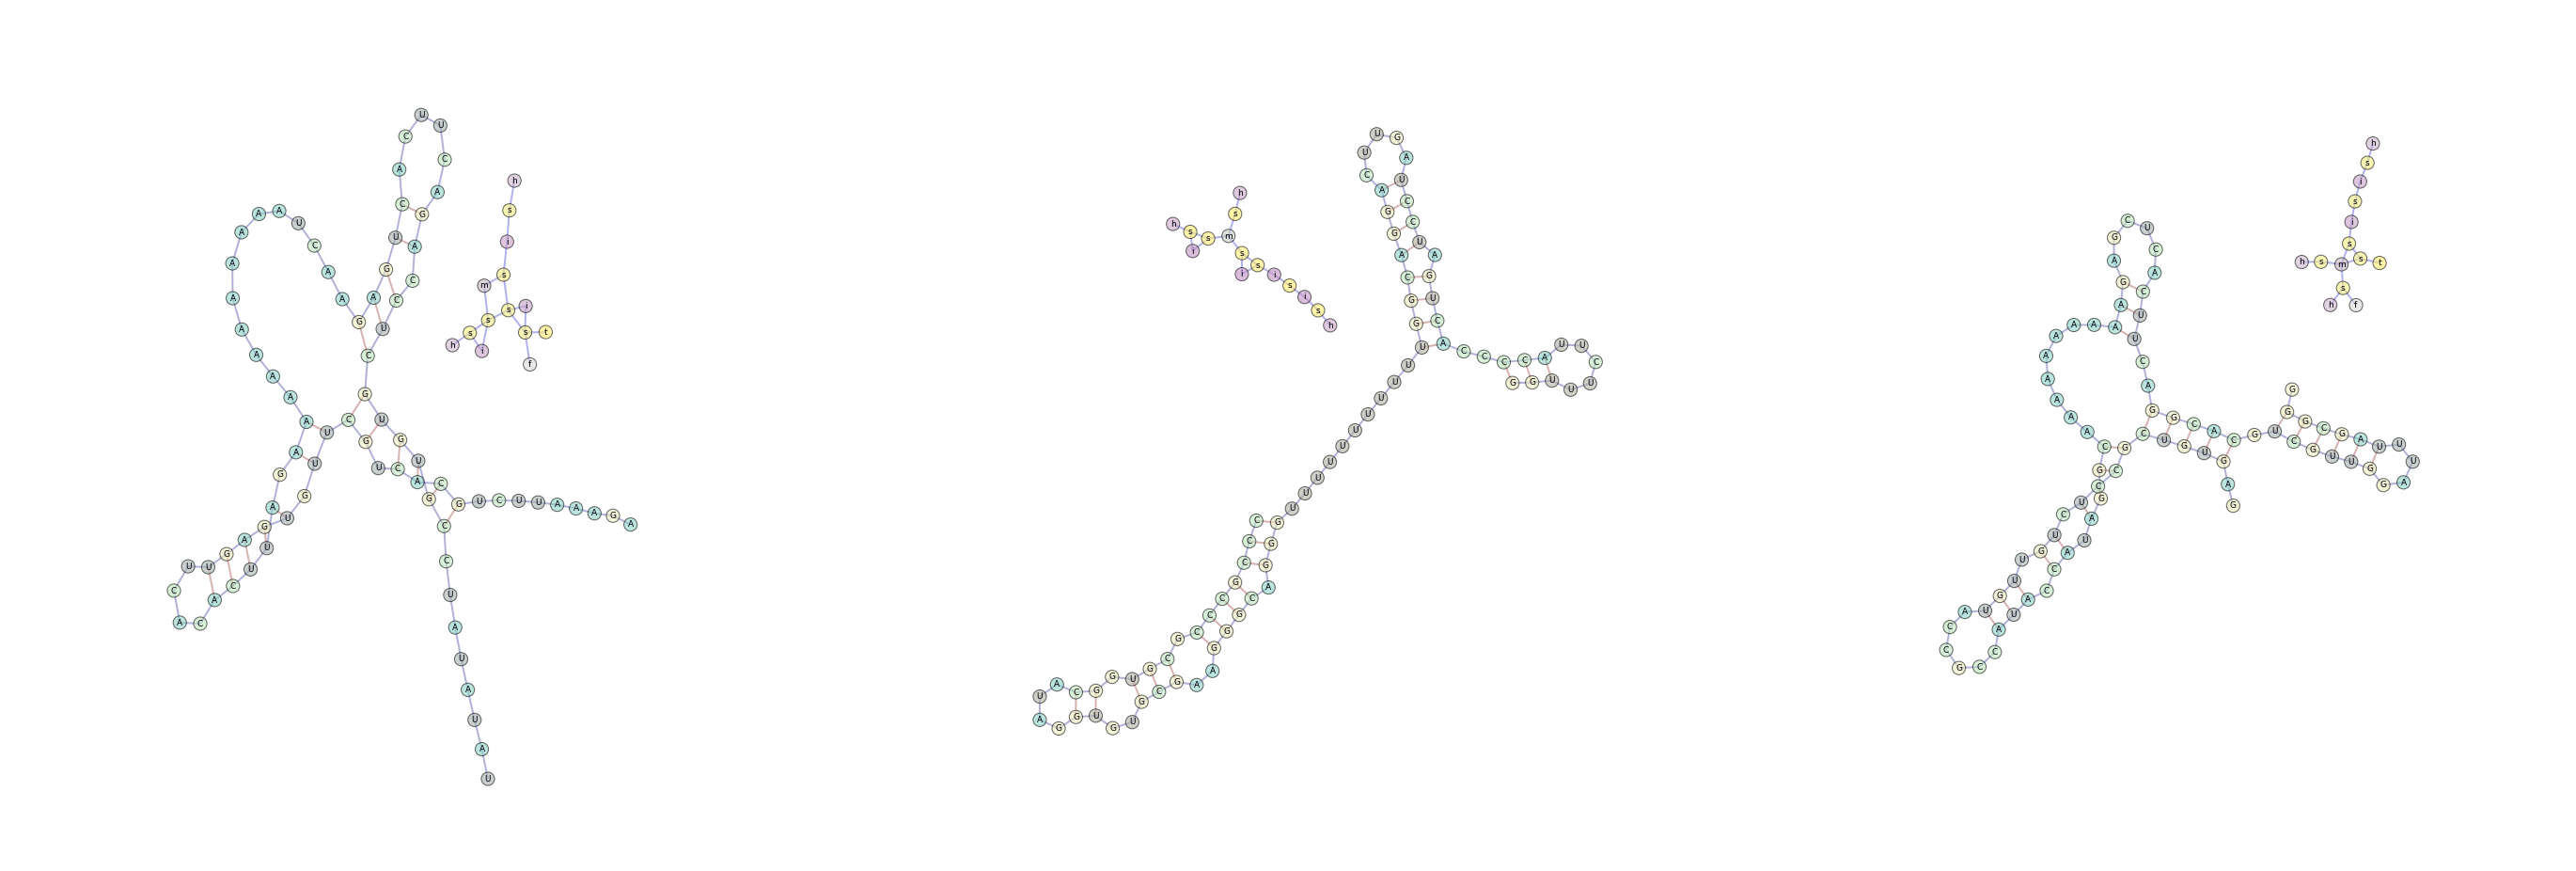

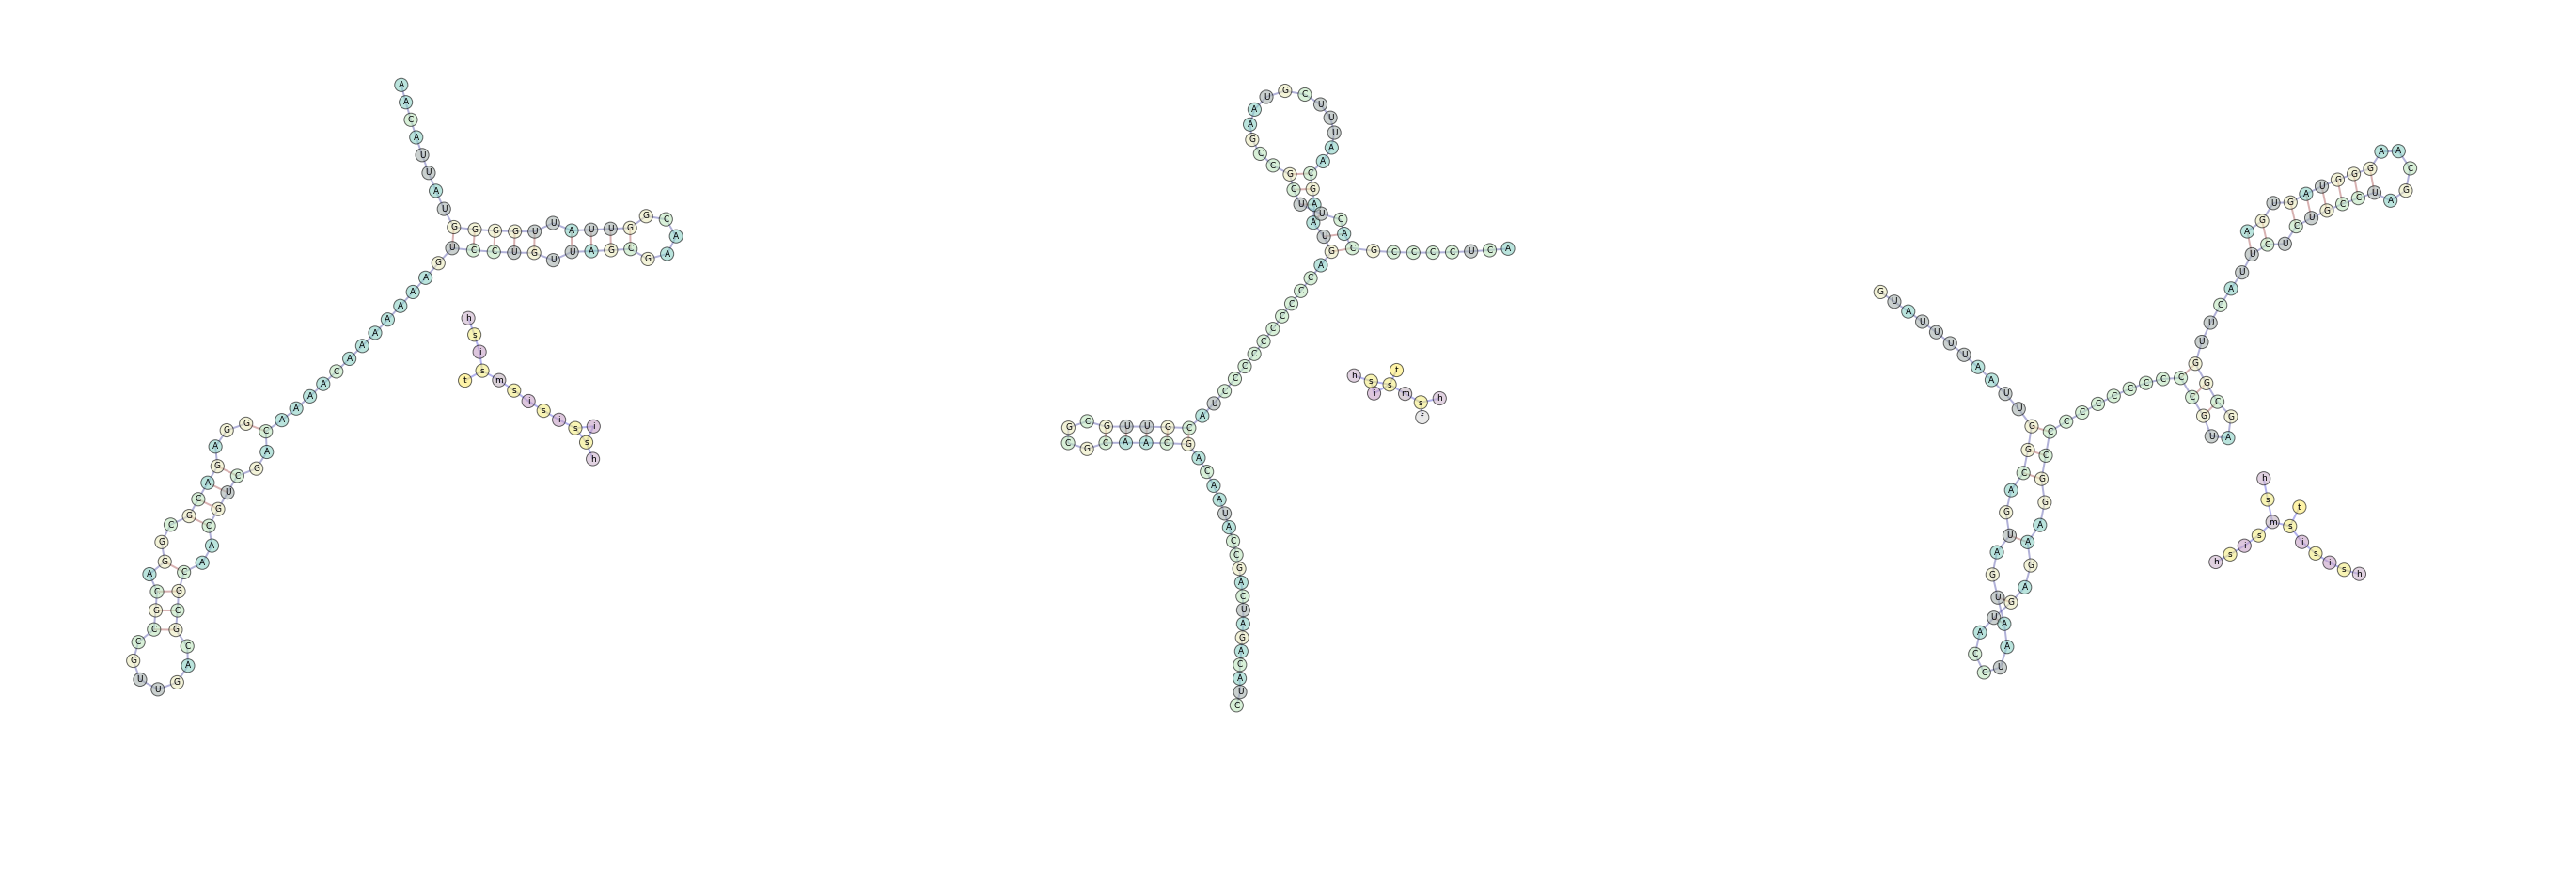

--------------------------------------------------------------------------------
cluster:9 size:9


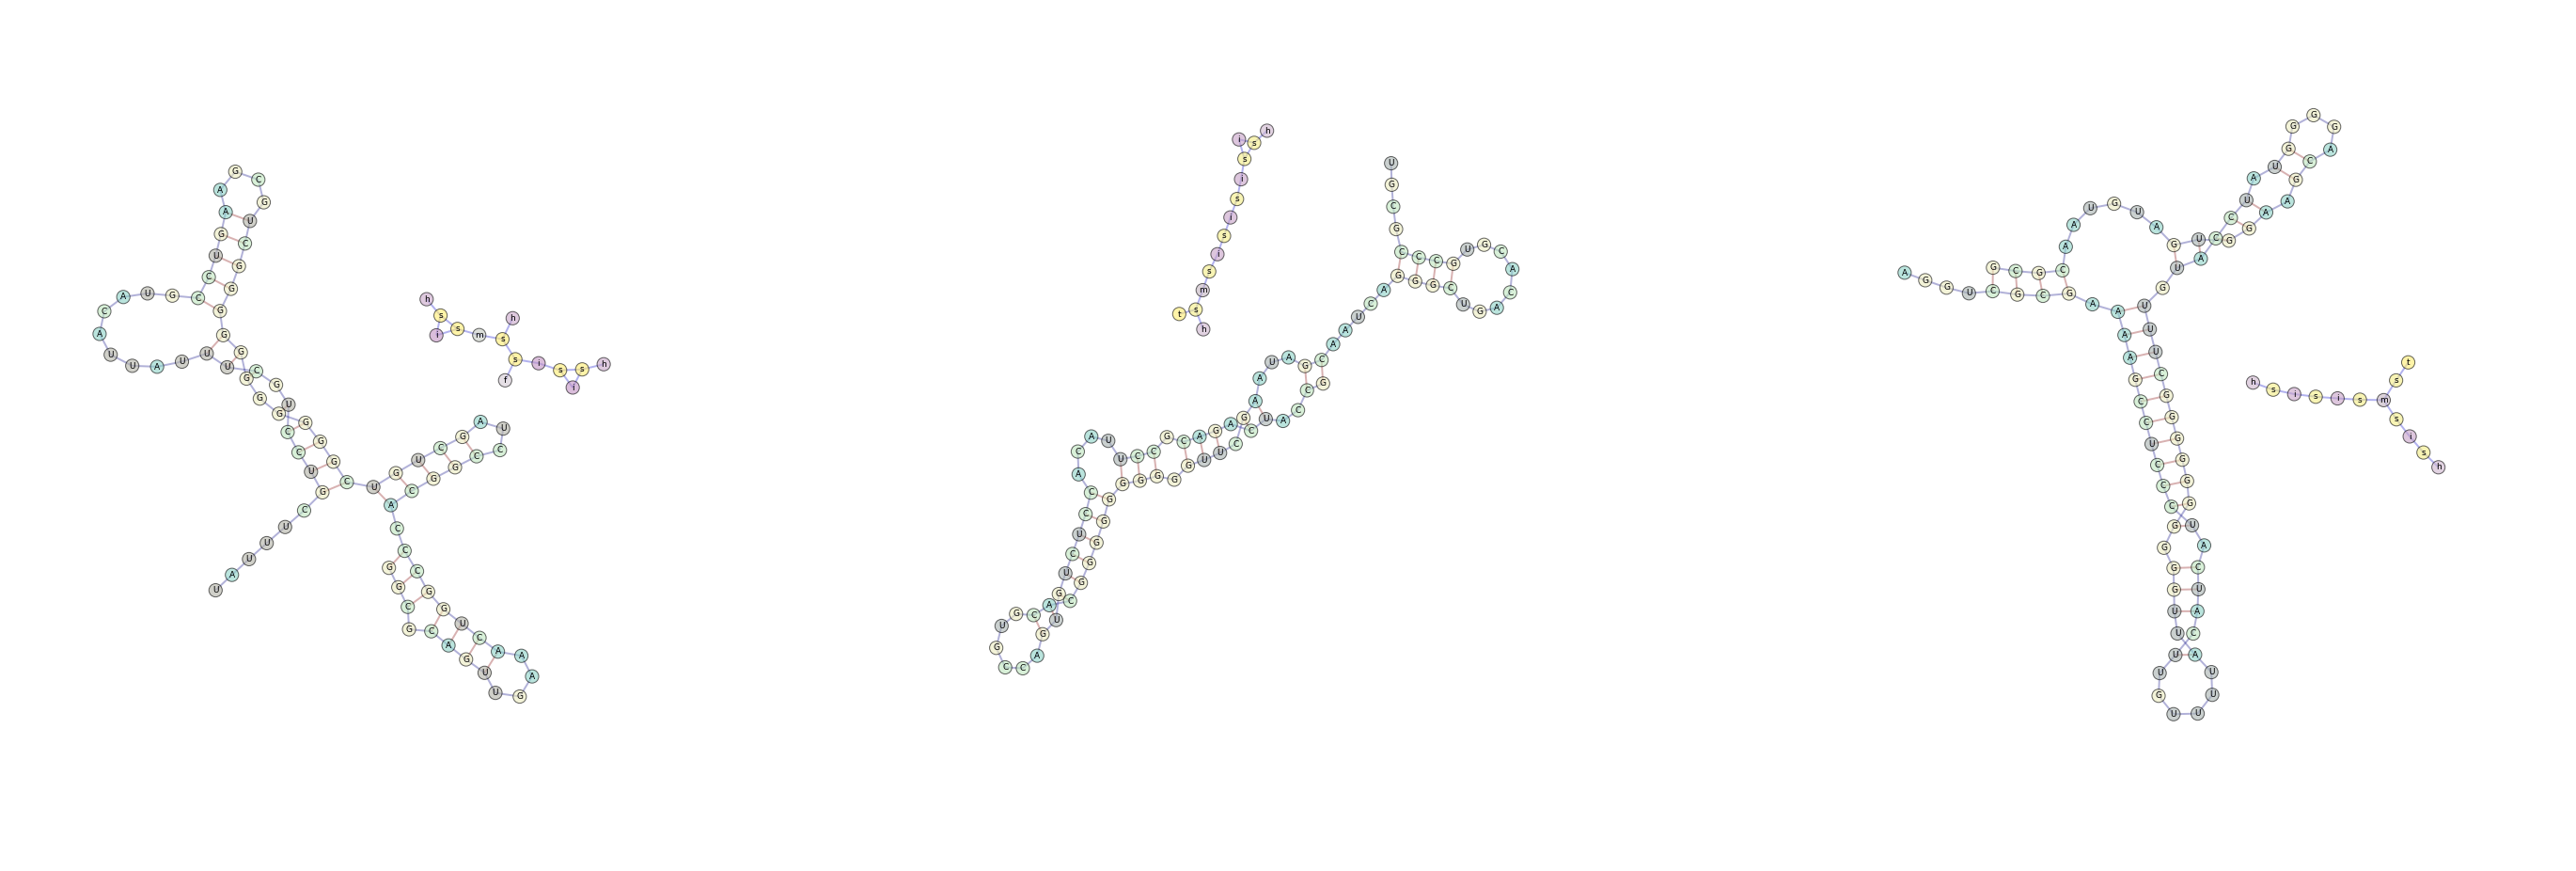

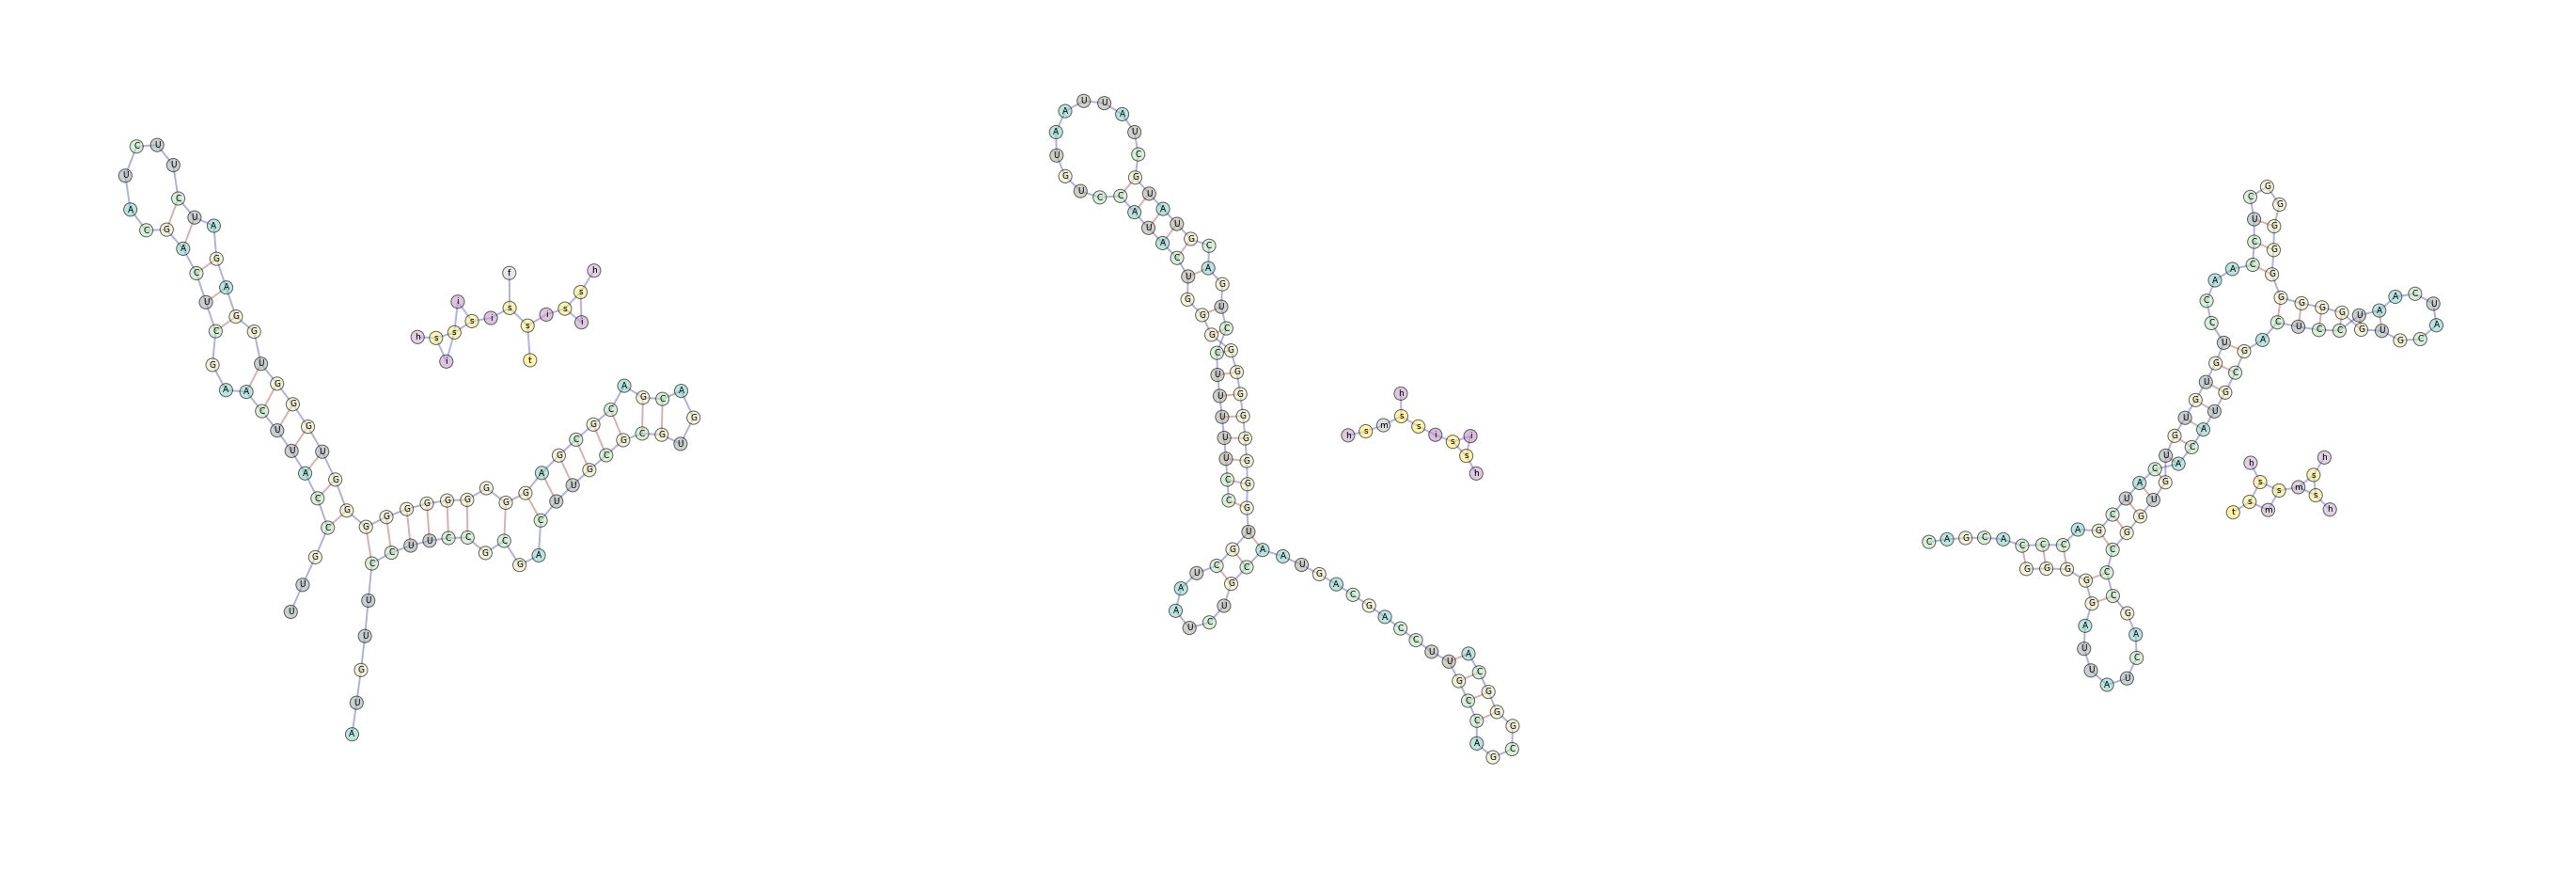

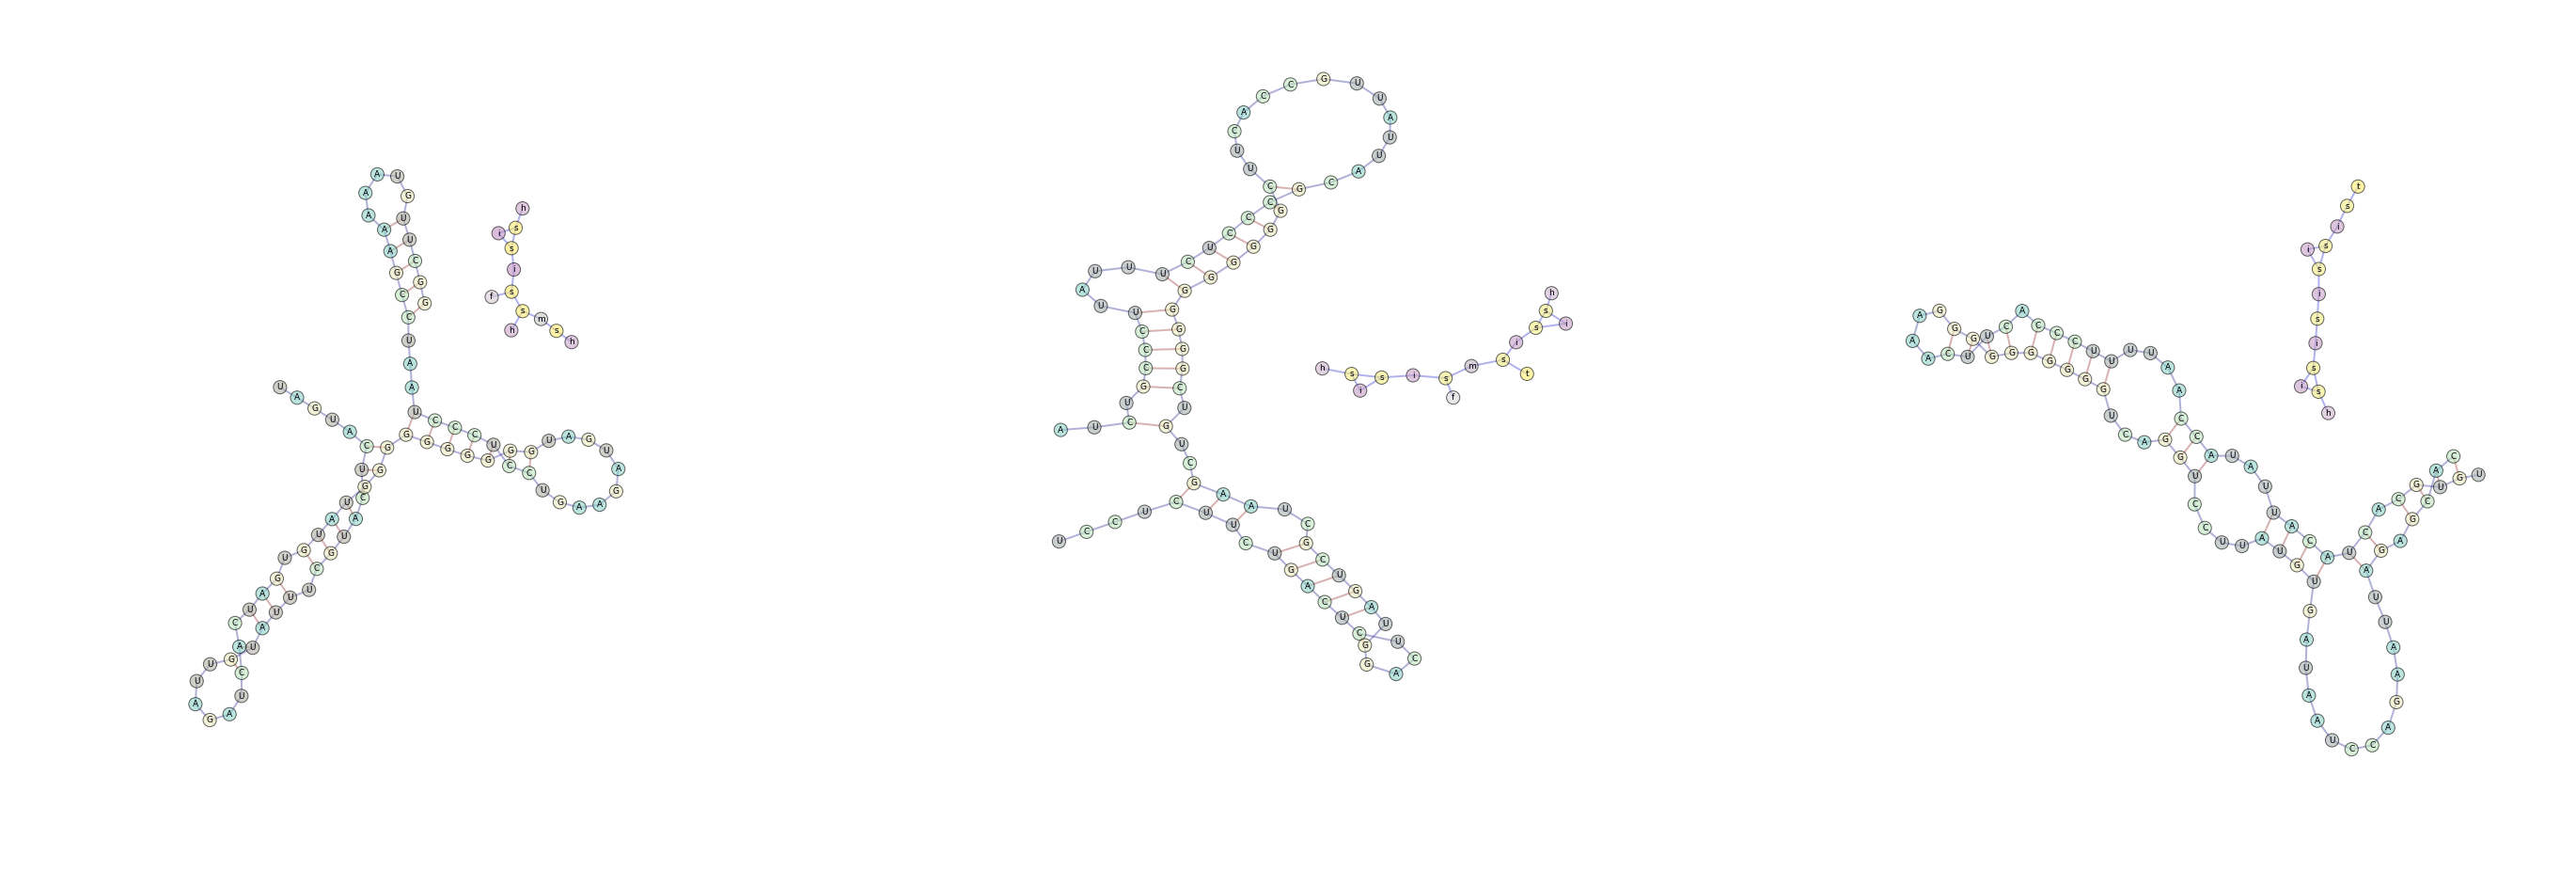

--------------------------------------------------------------------------------
cluster:10 size:7


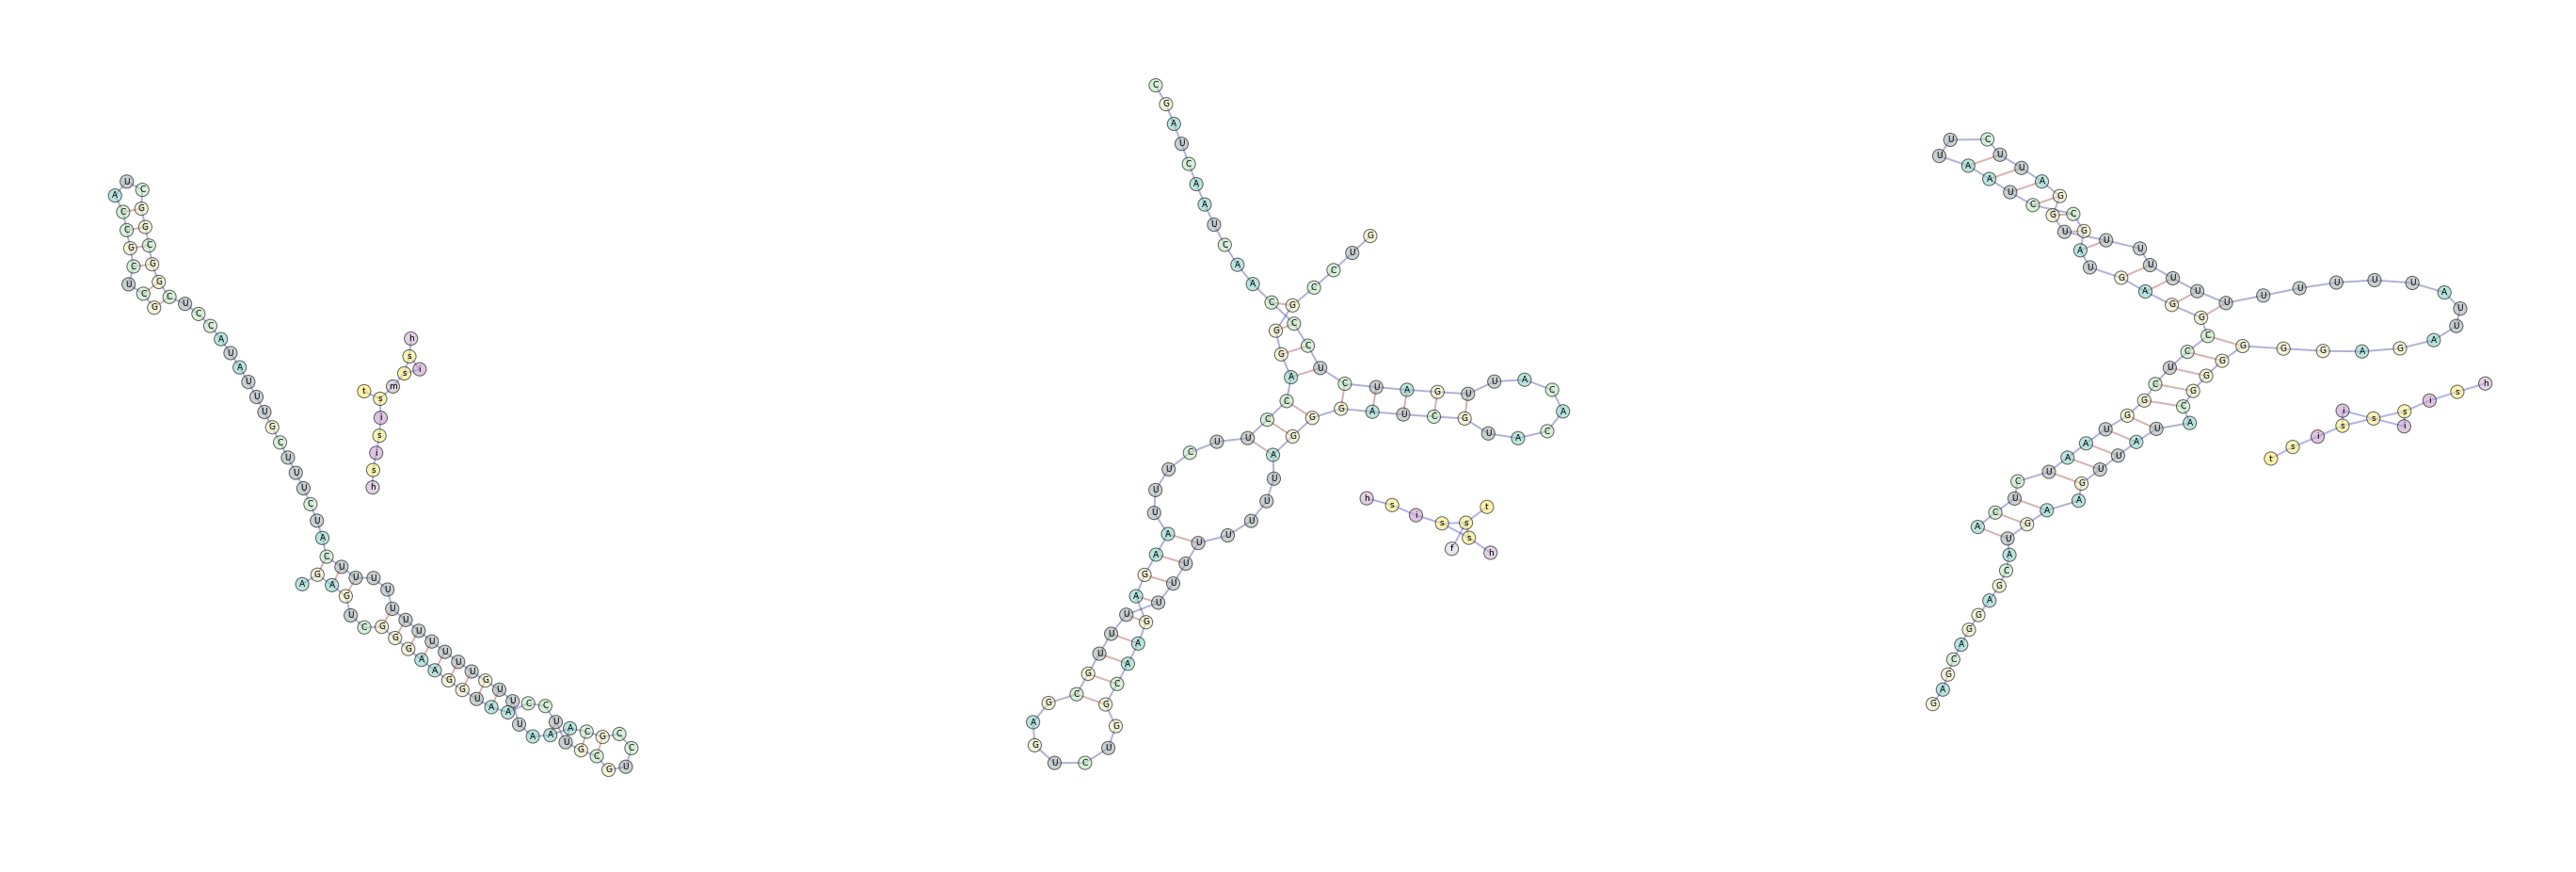

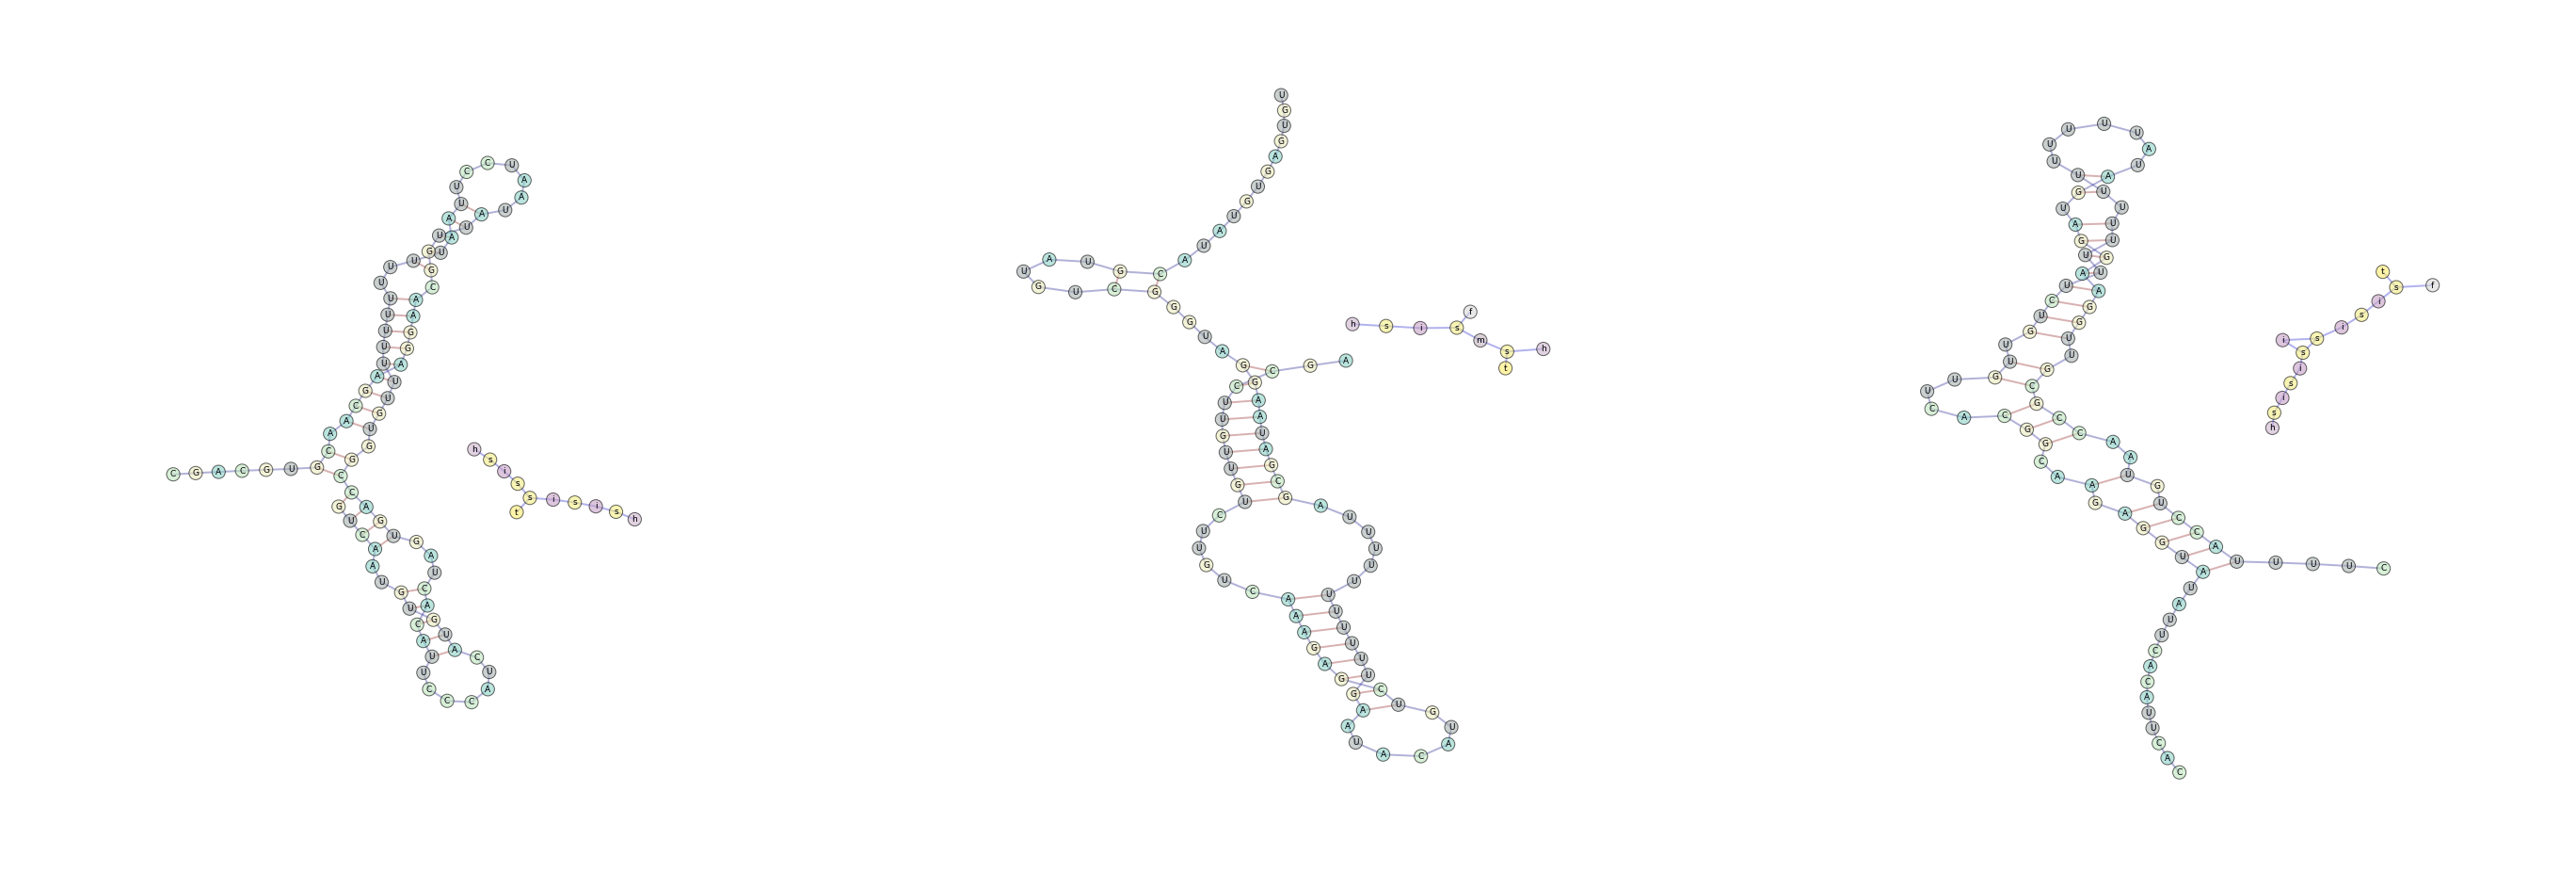

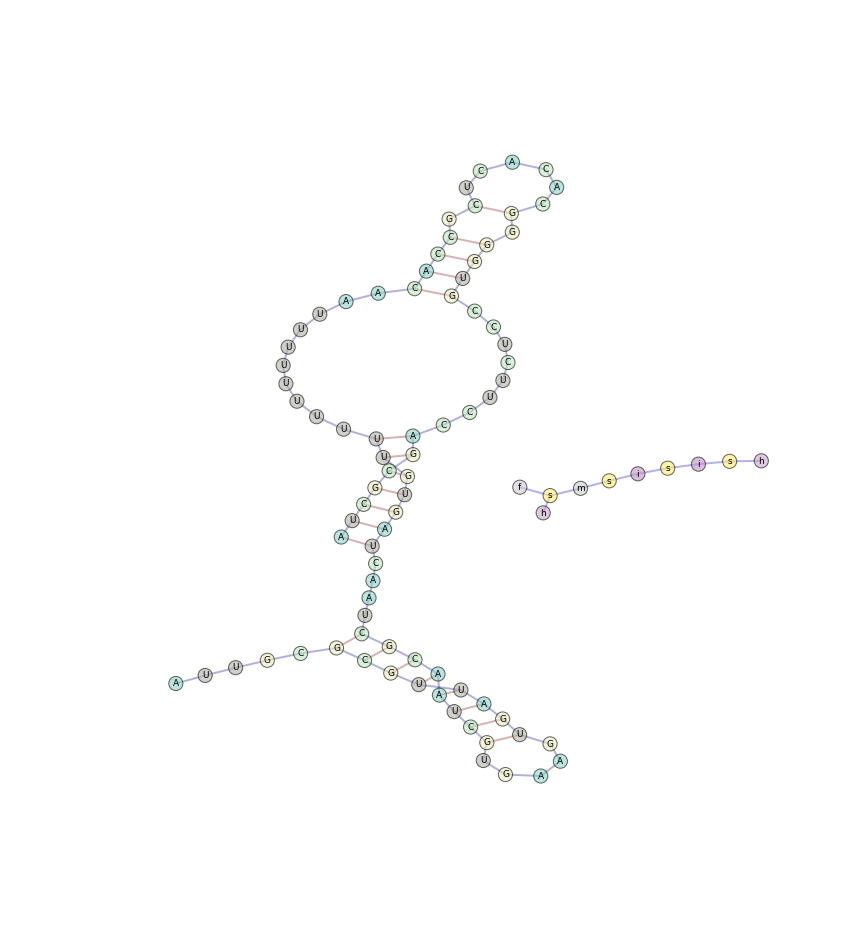

--------------------------------------------------------------------------------
cluster:11 size:6


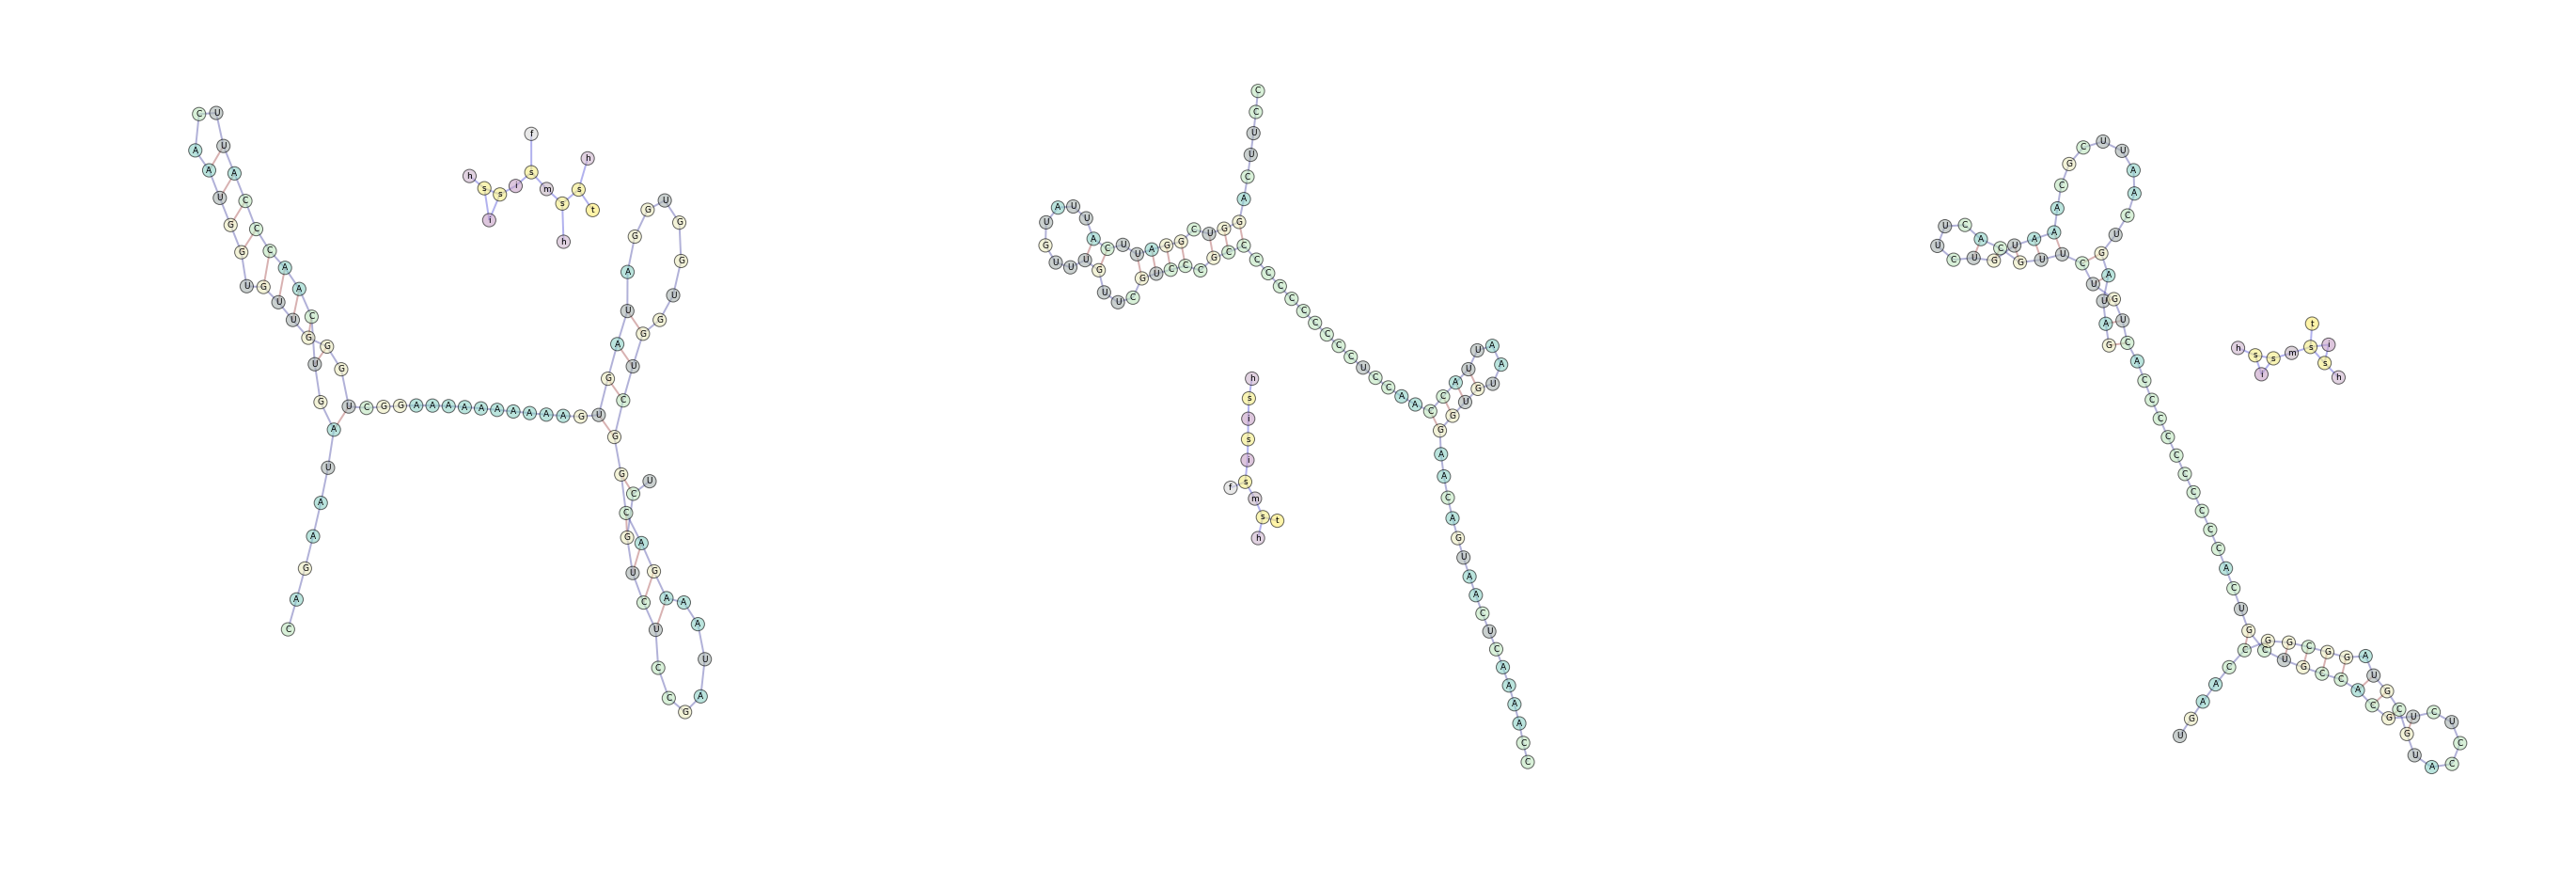

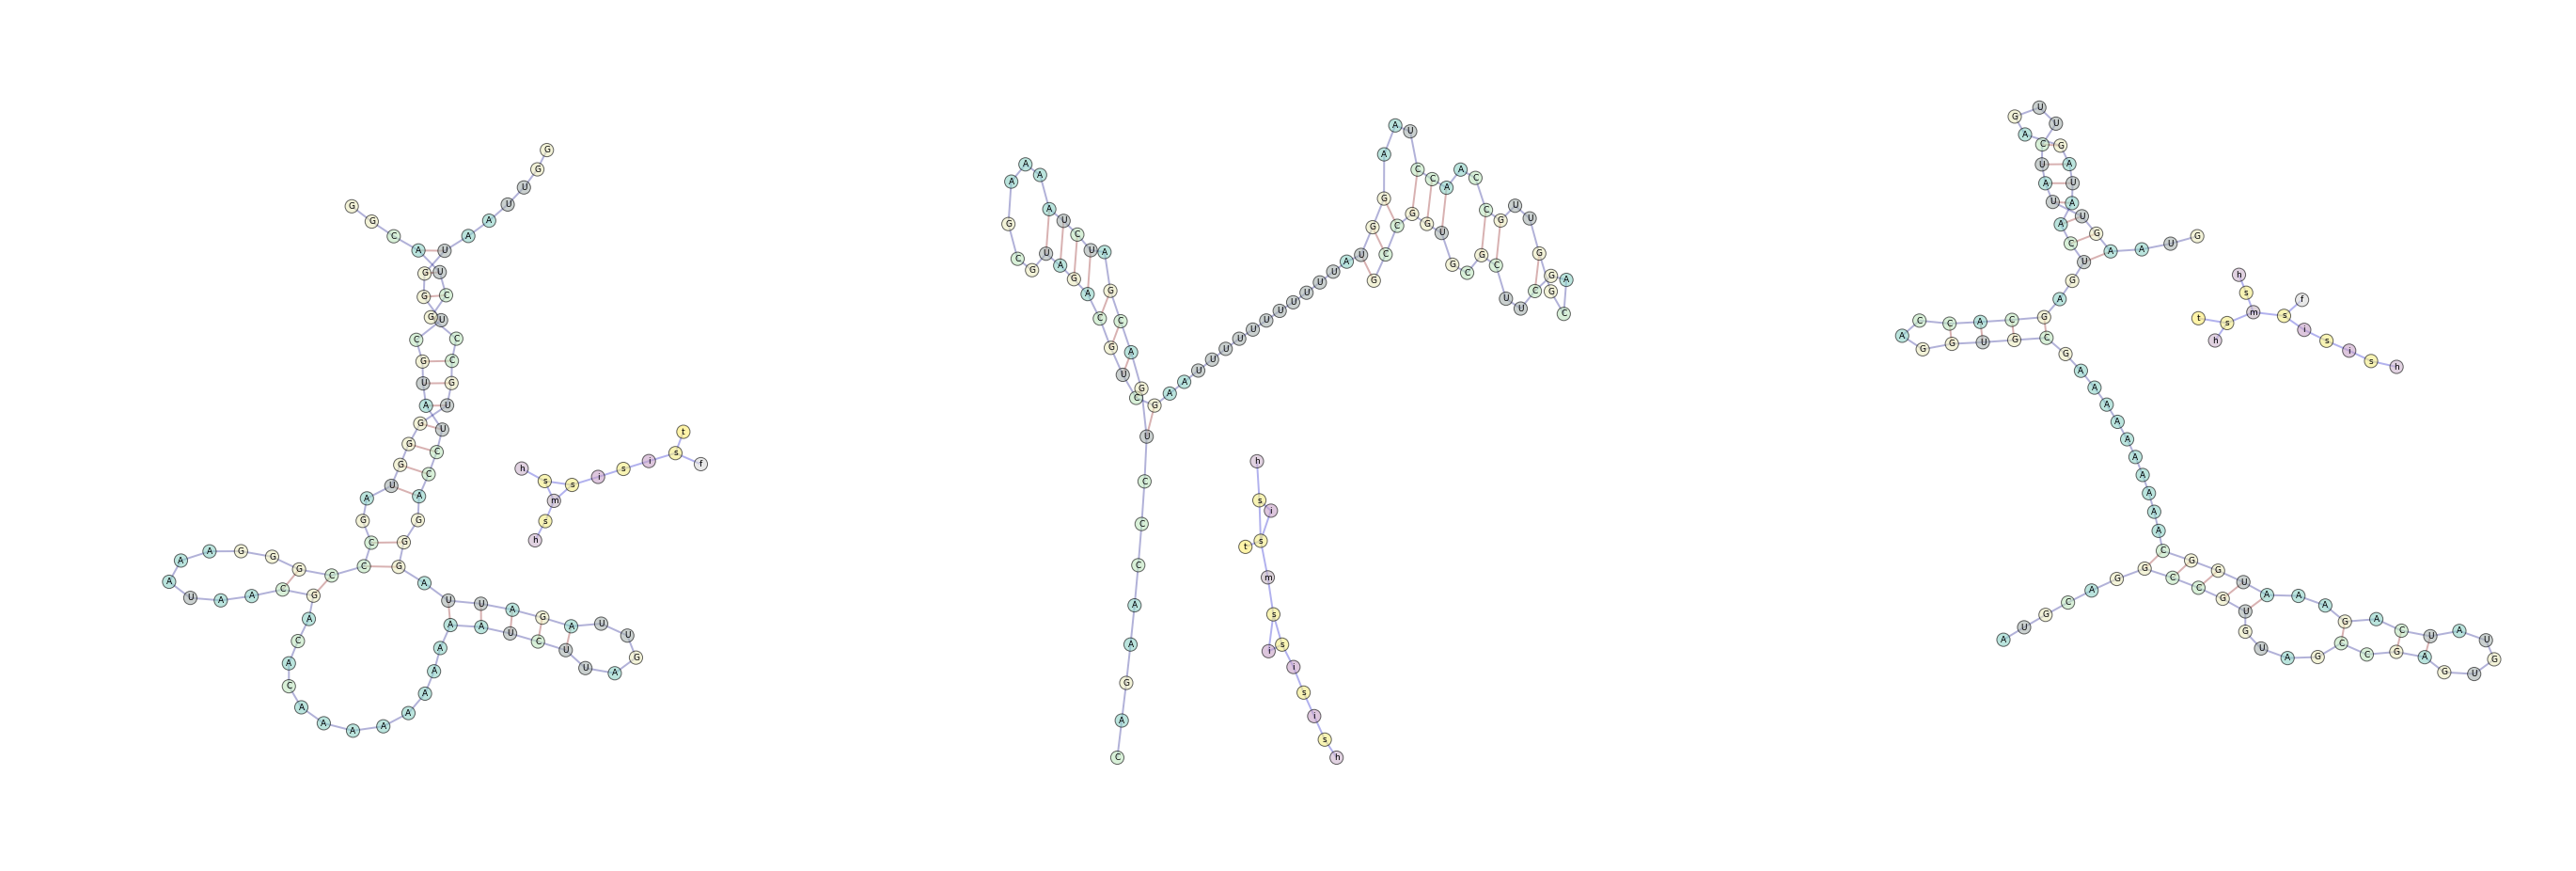

--------------------------------------------------------------------------------
cluster:12 size:6


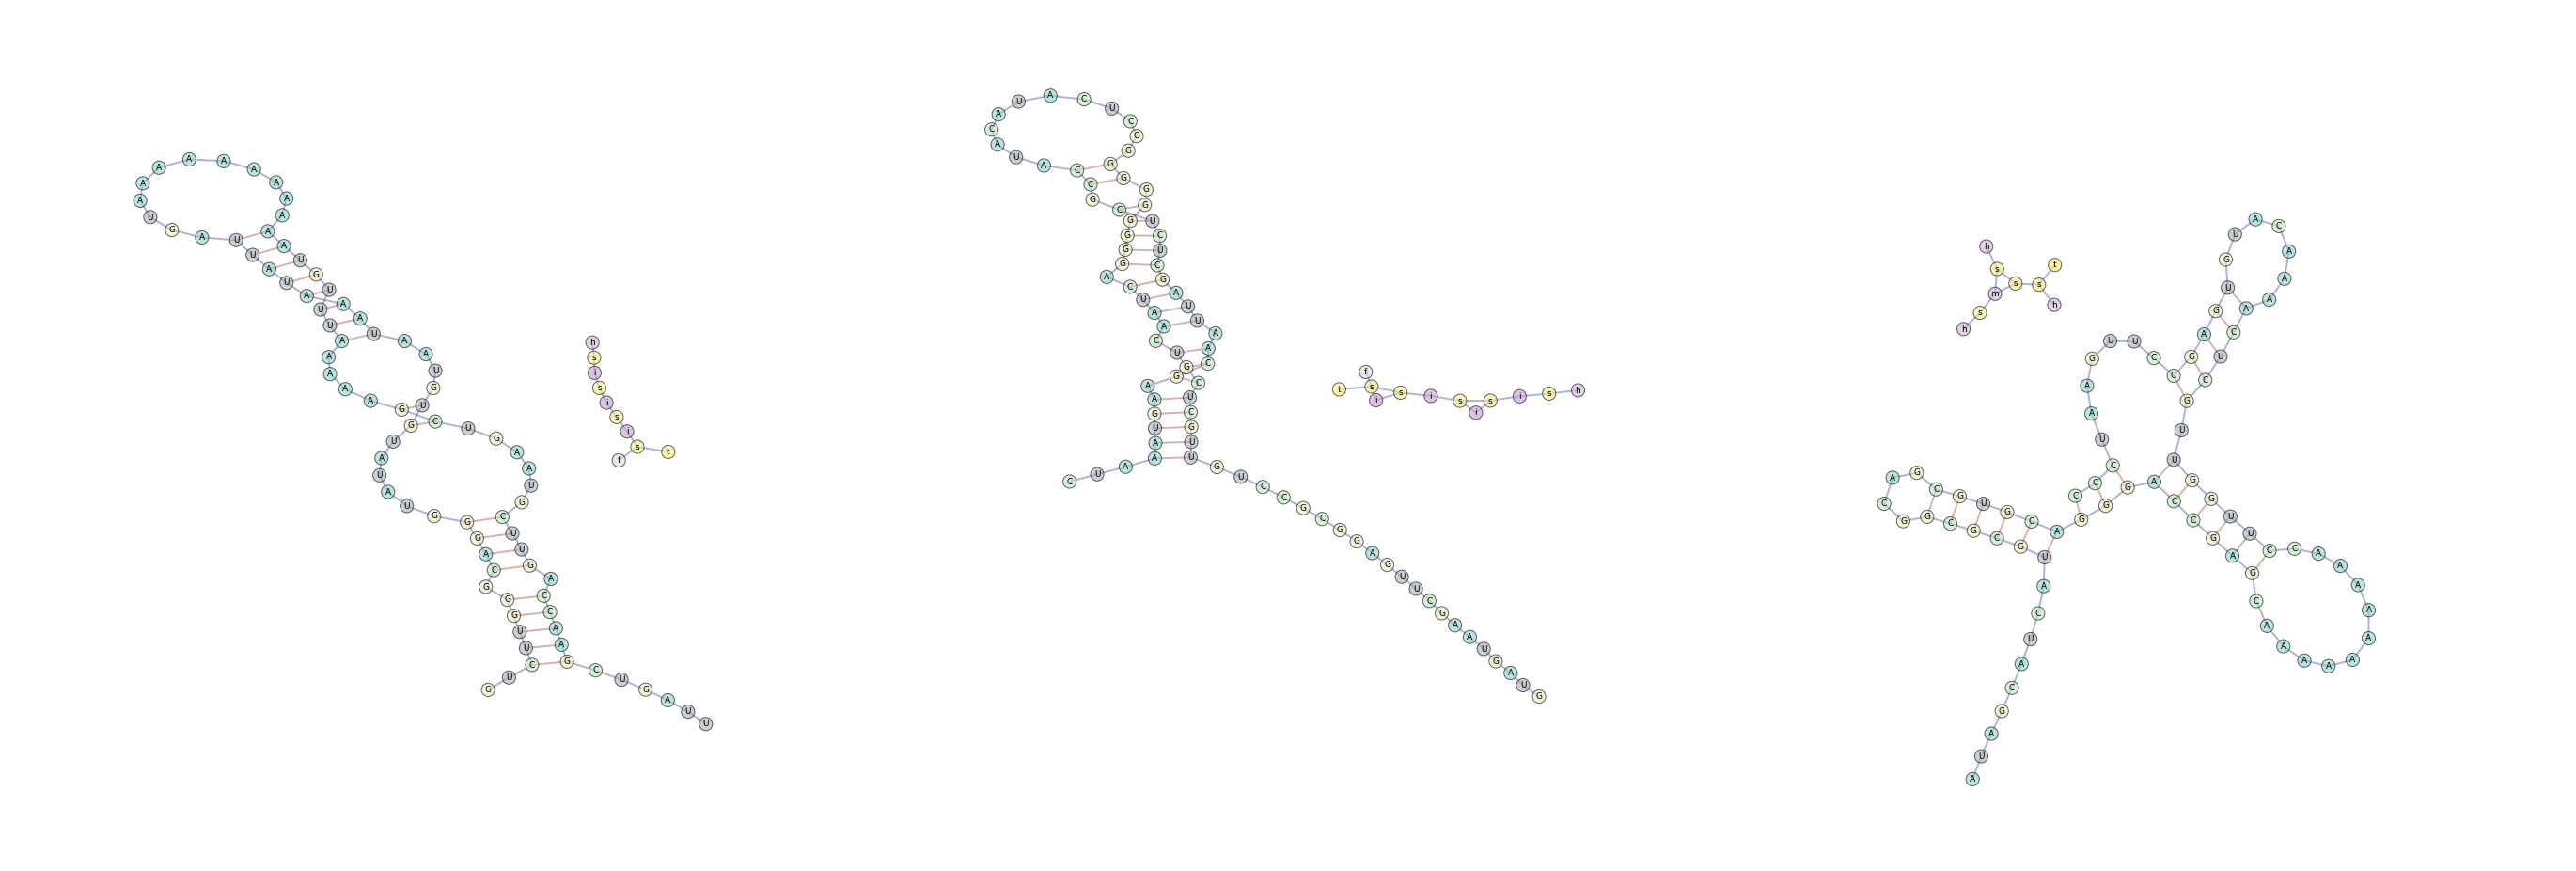

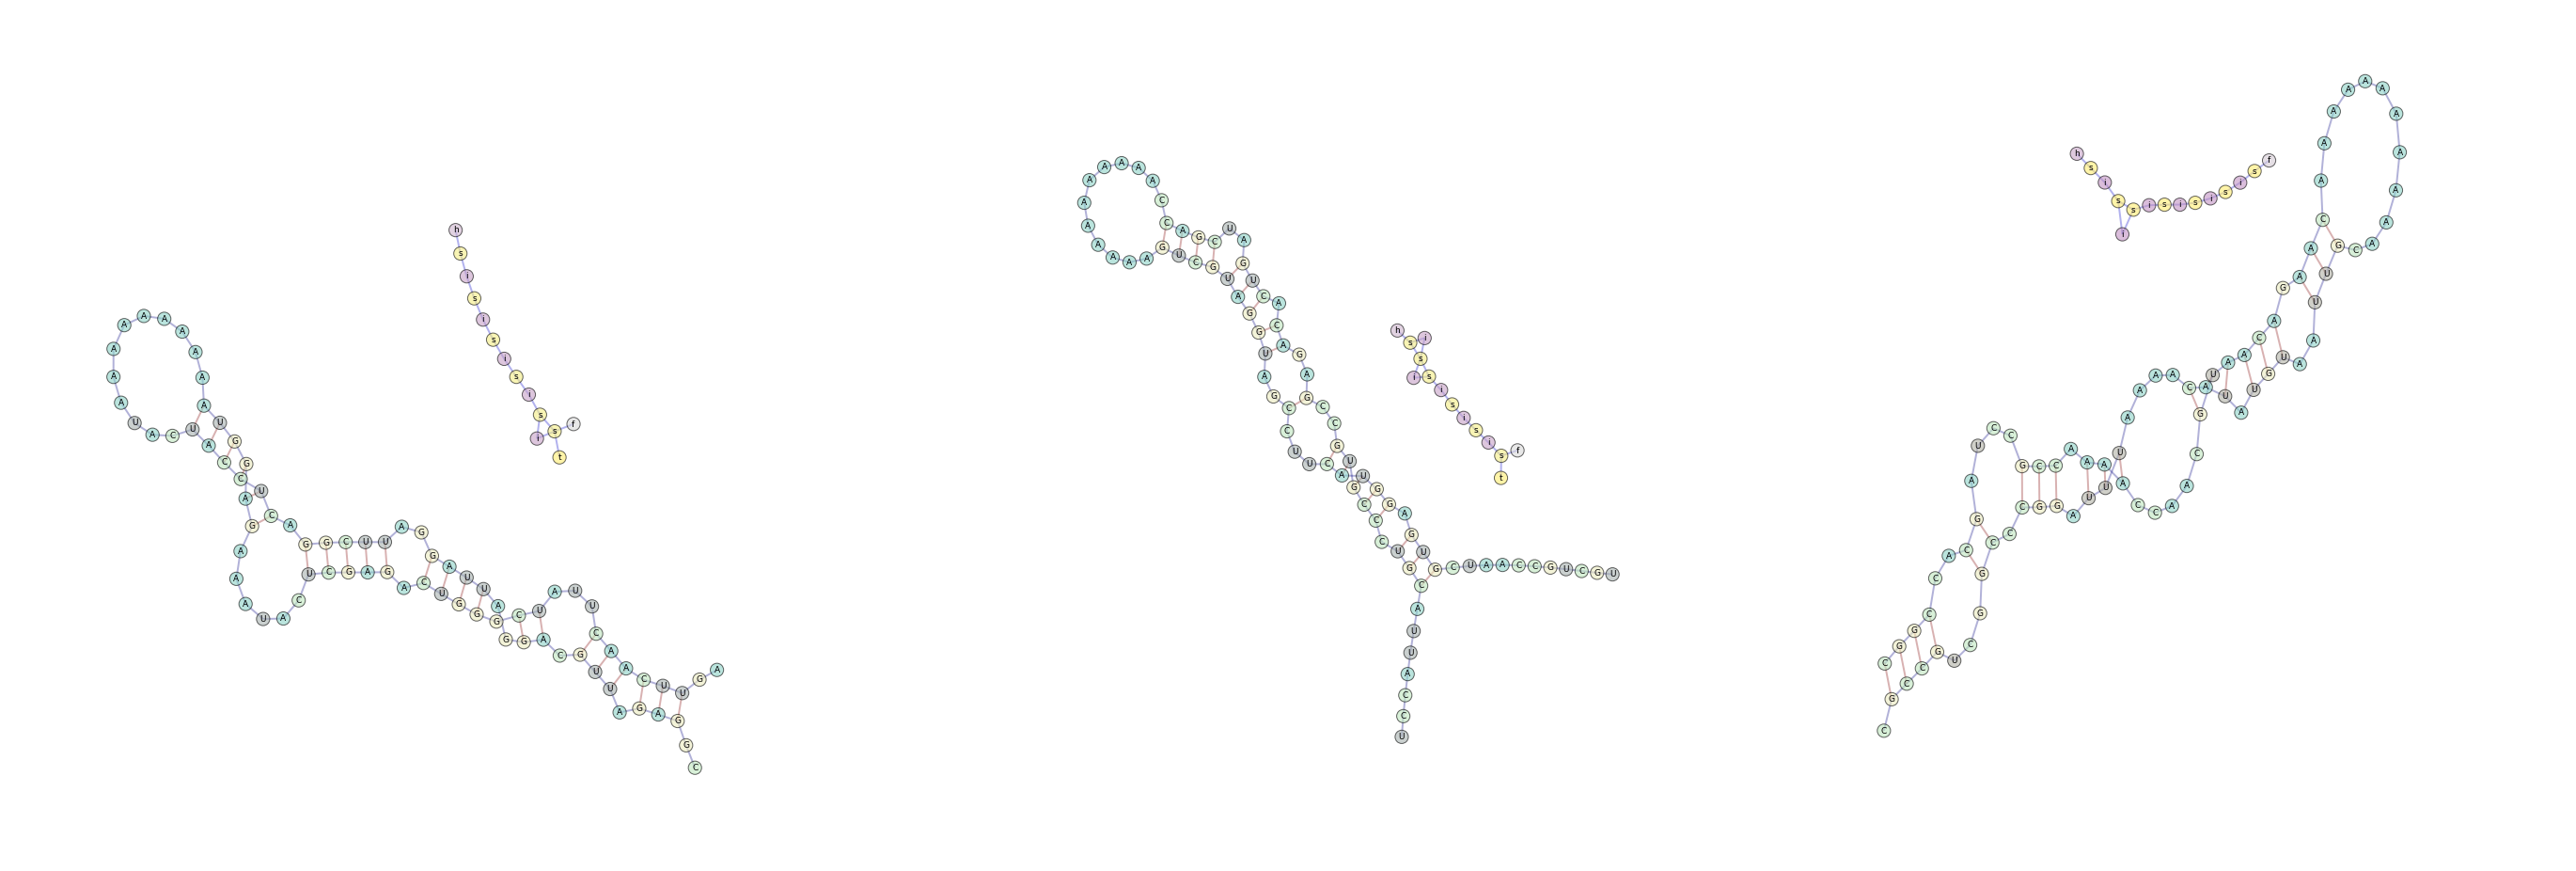

--------------------------------------------------------------------------------
cluster:16 size:9


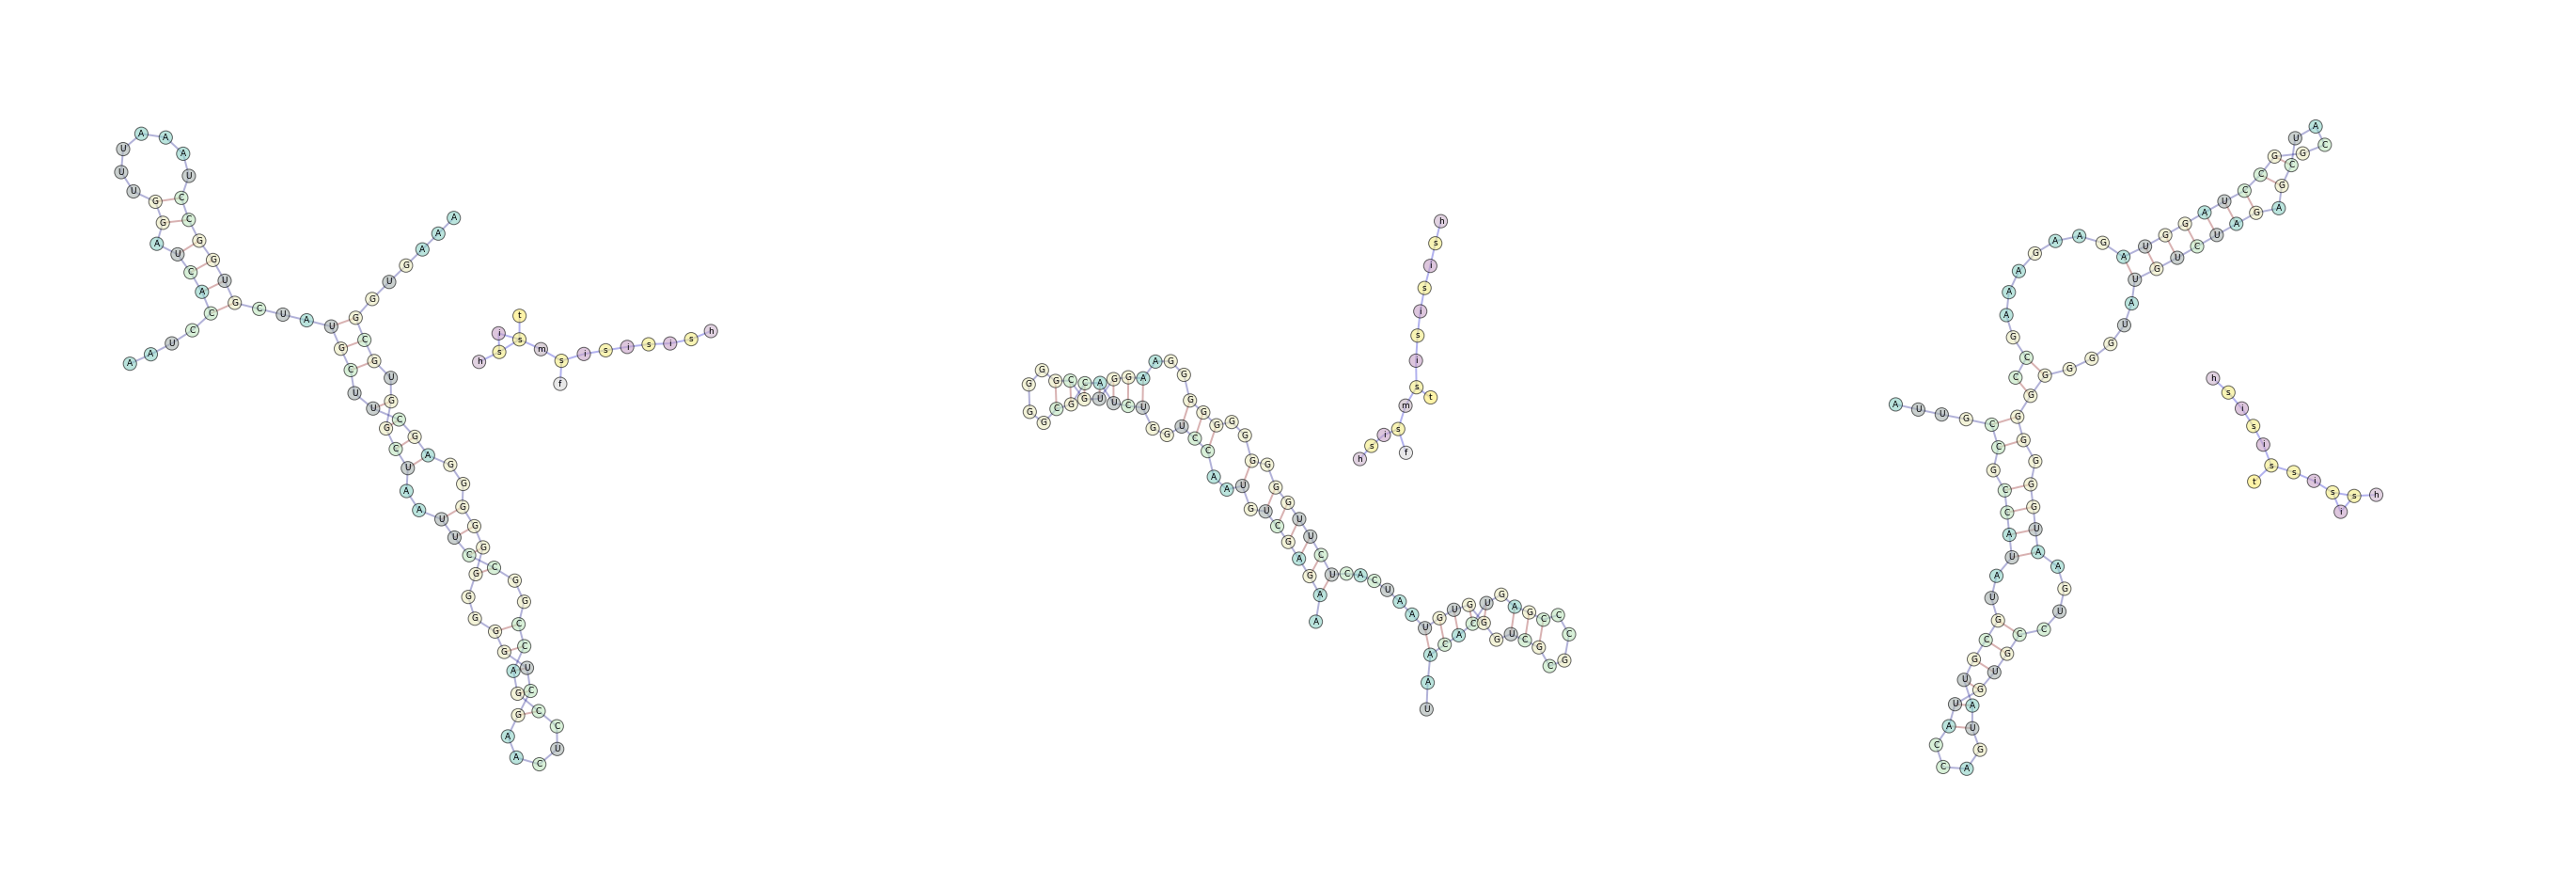

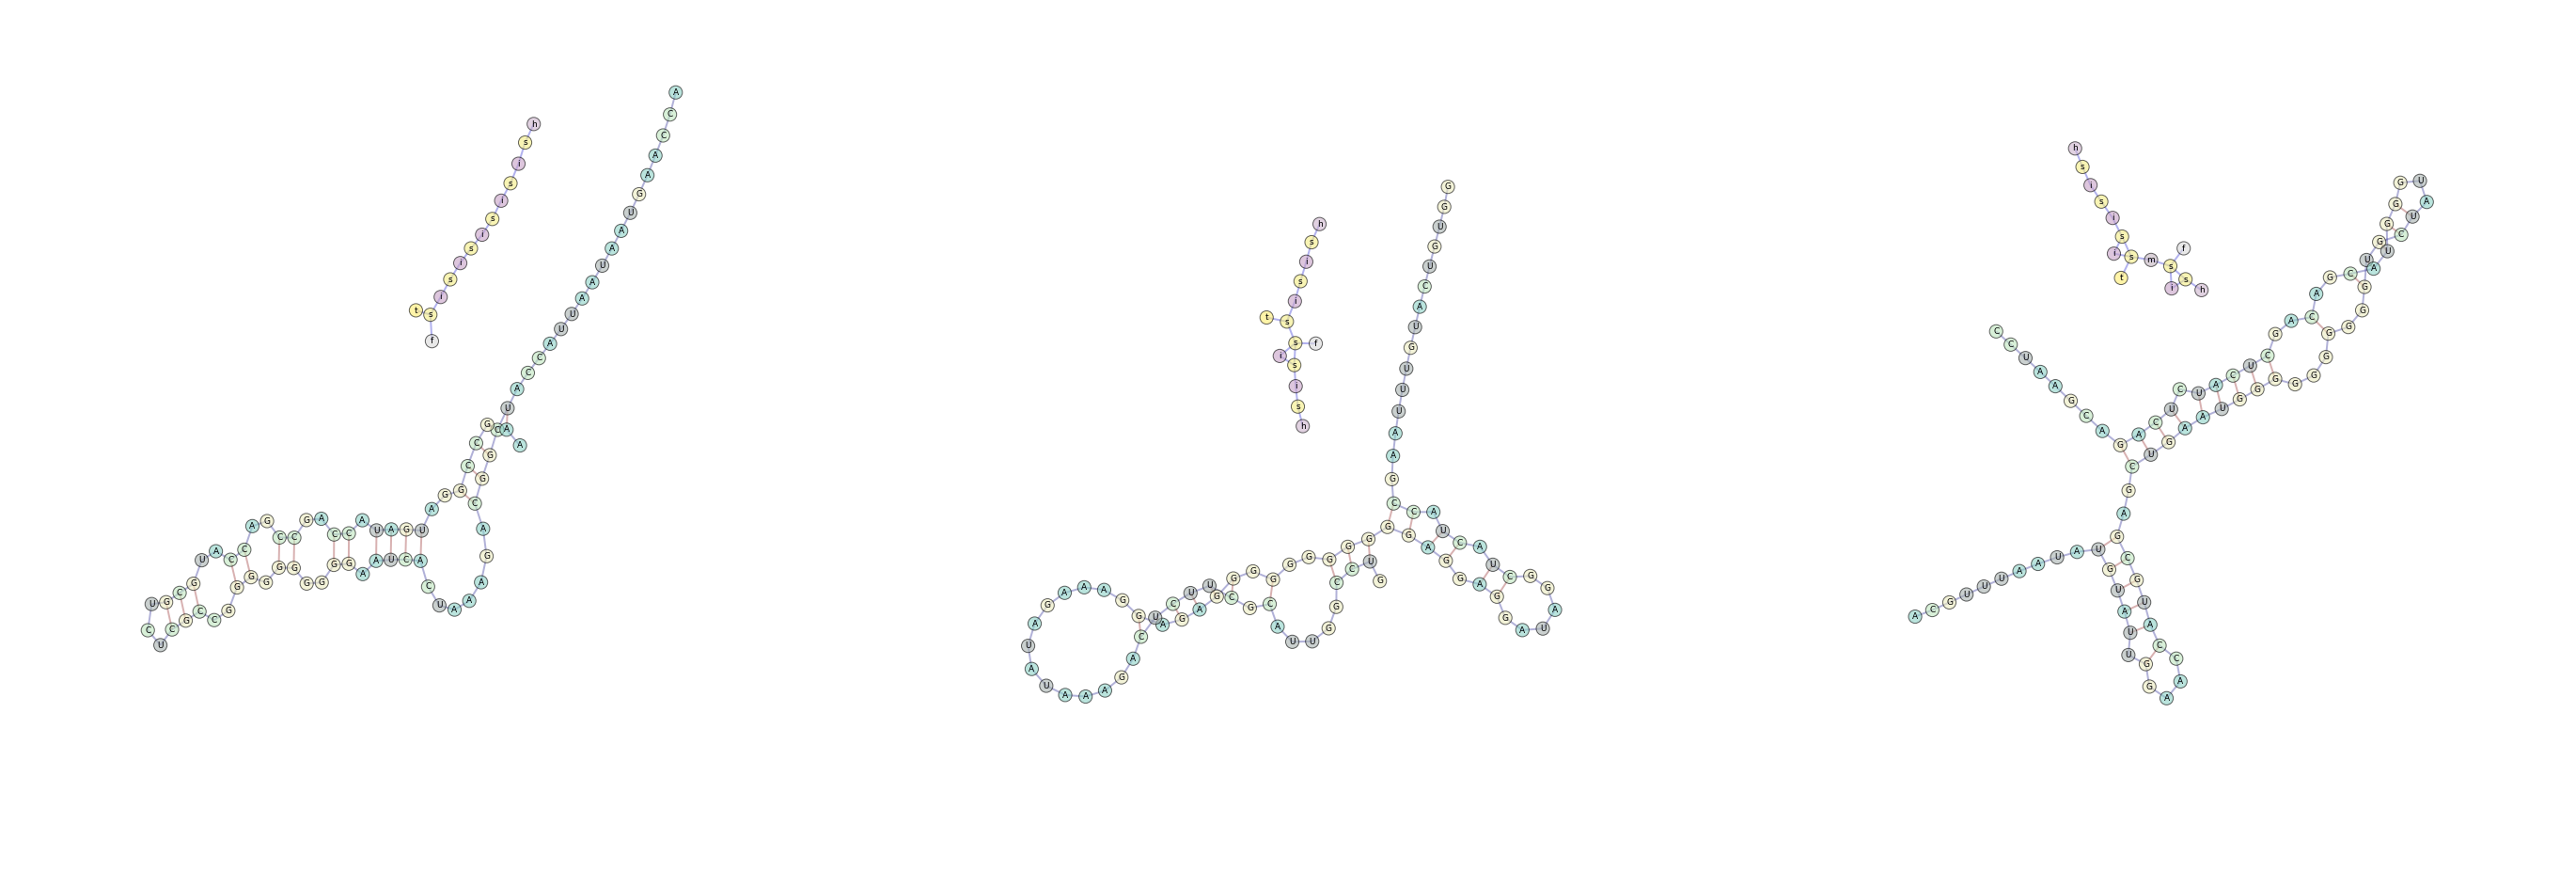

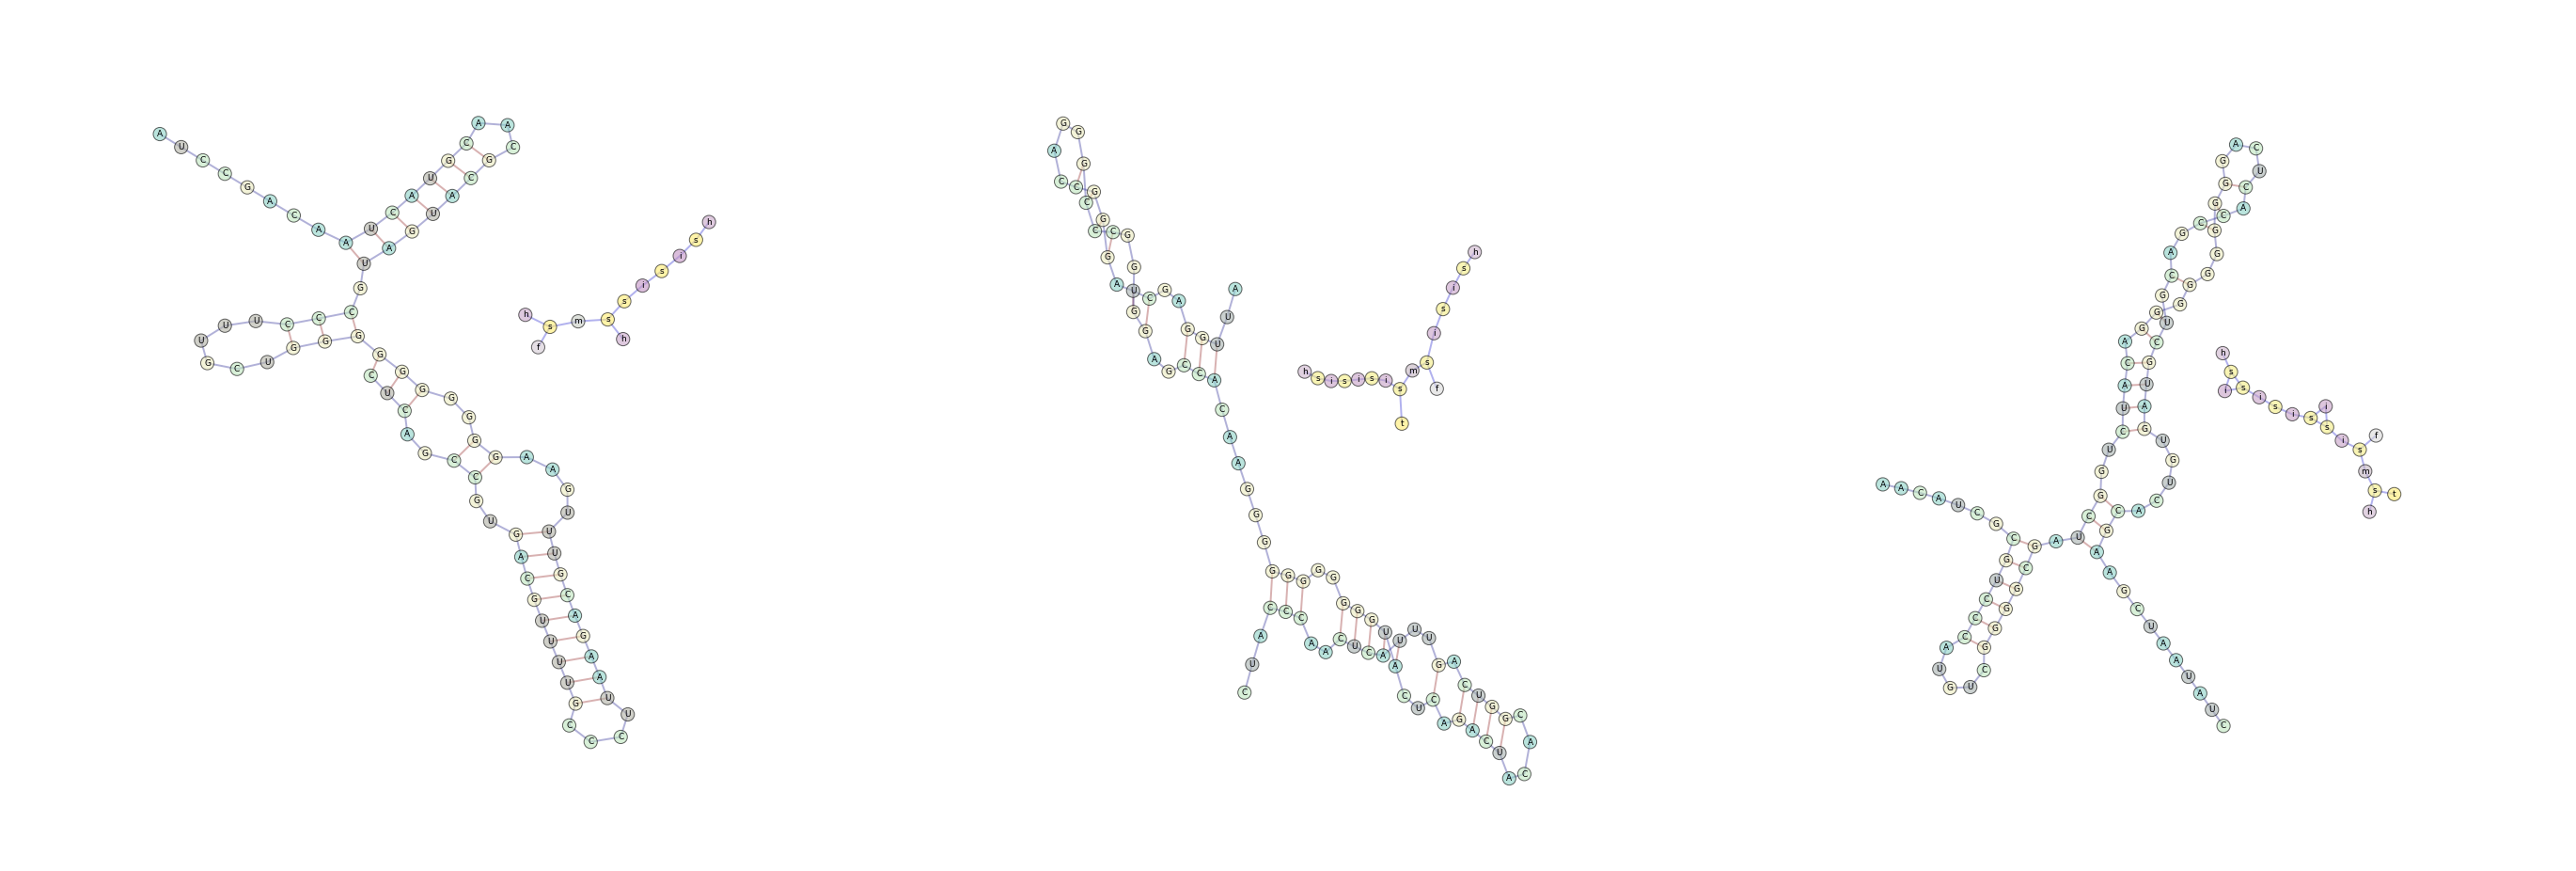

--------------------------------------------------------------------------------
cluster:17 size:12


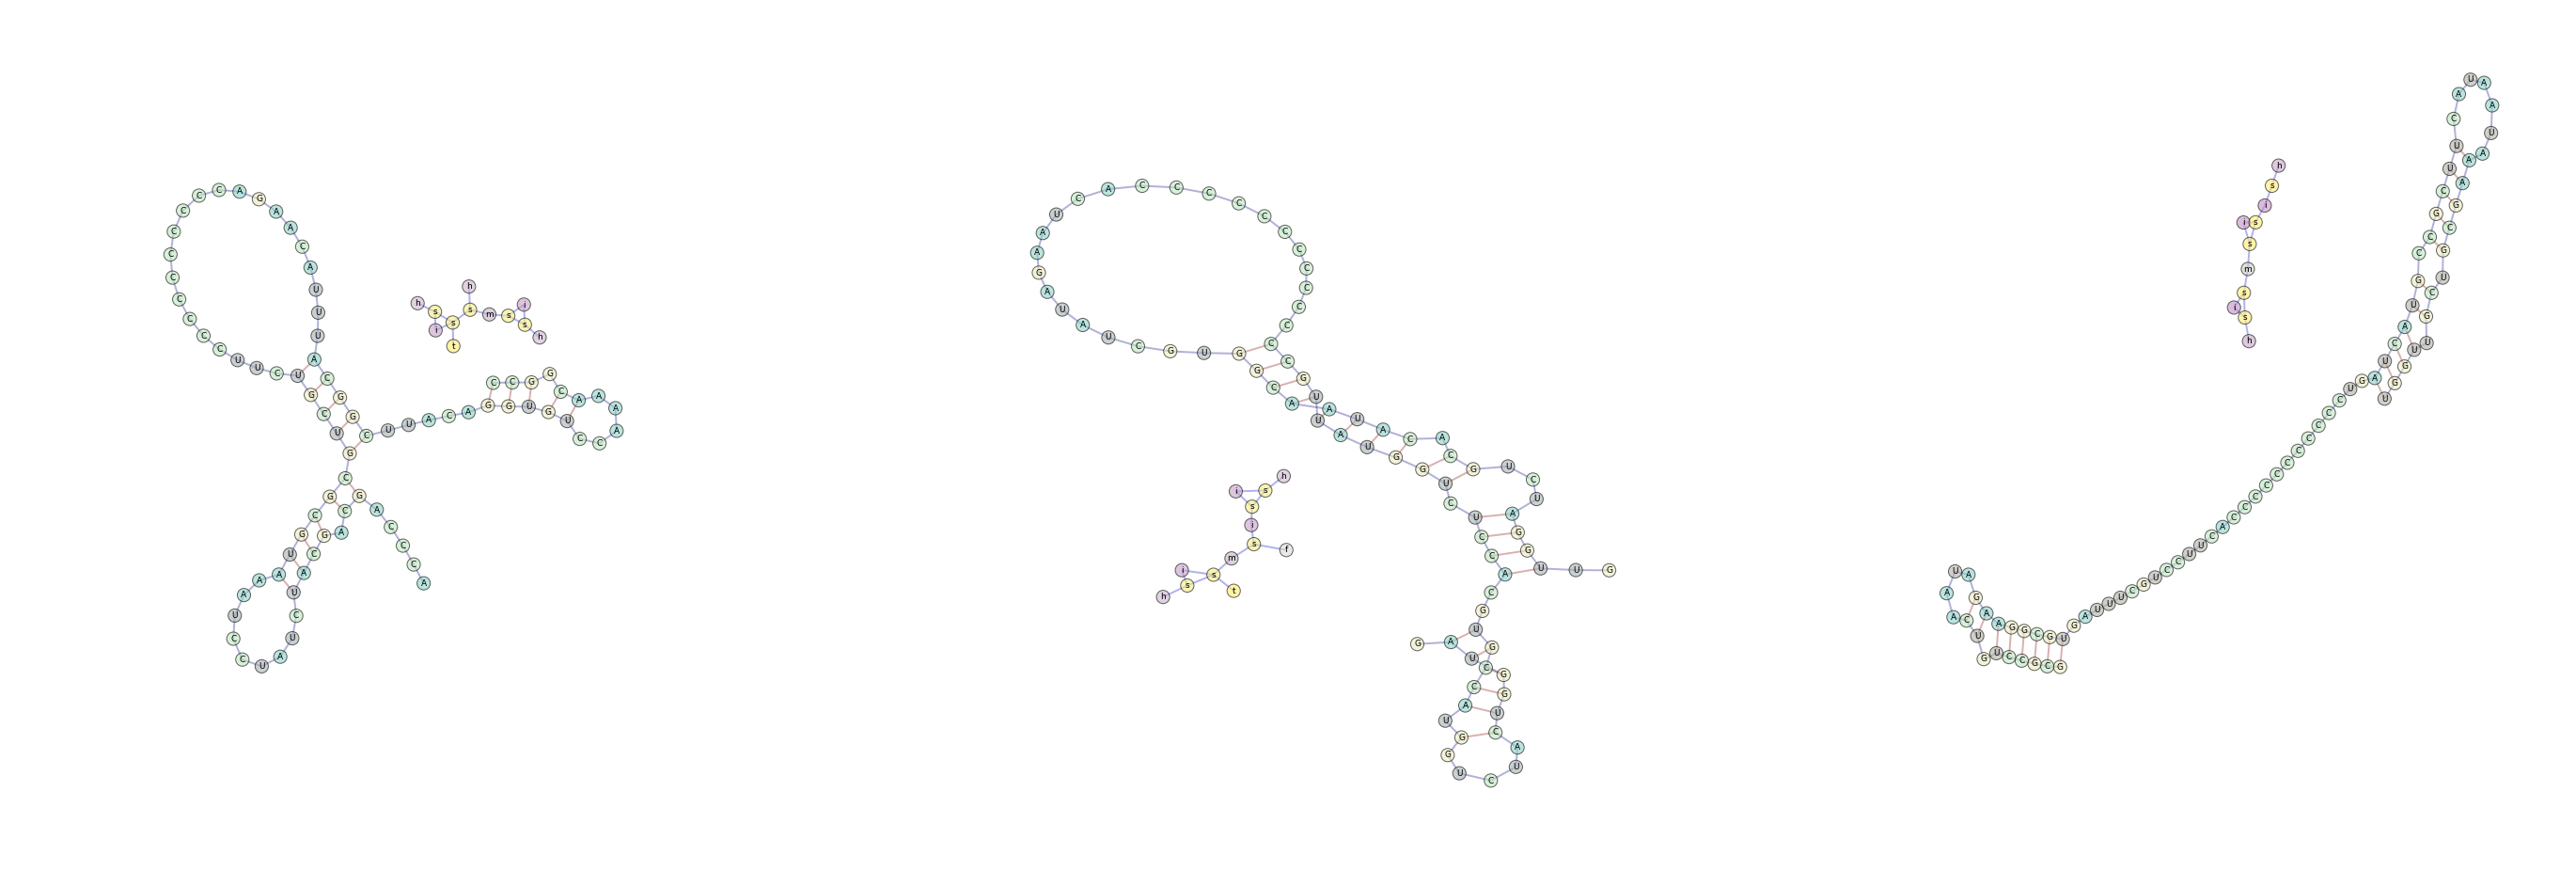

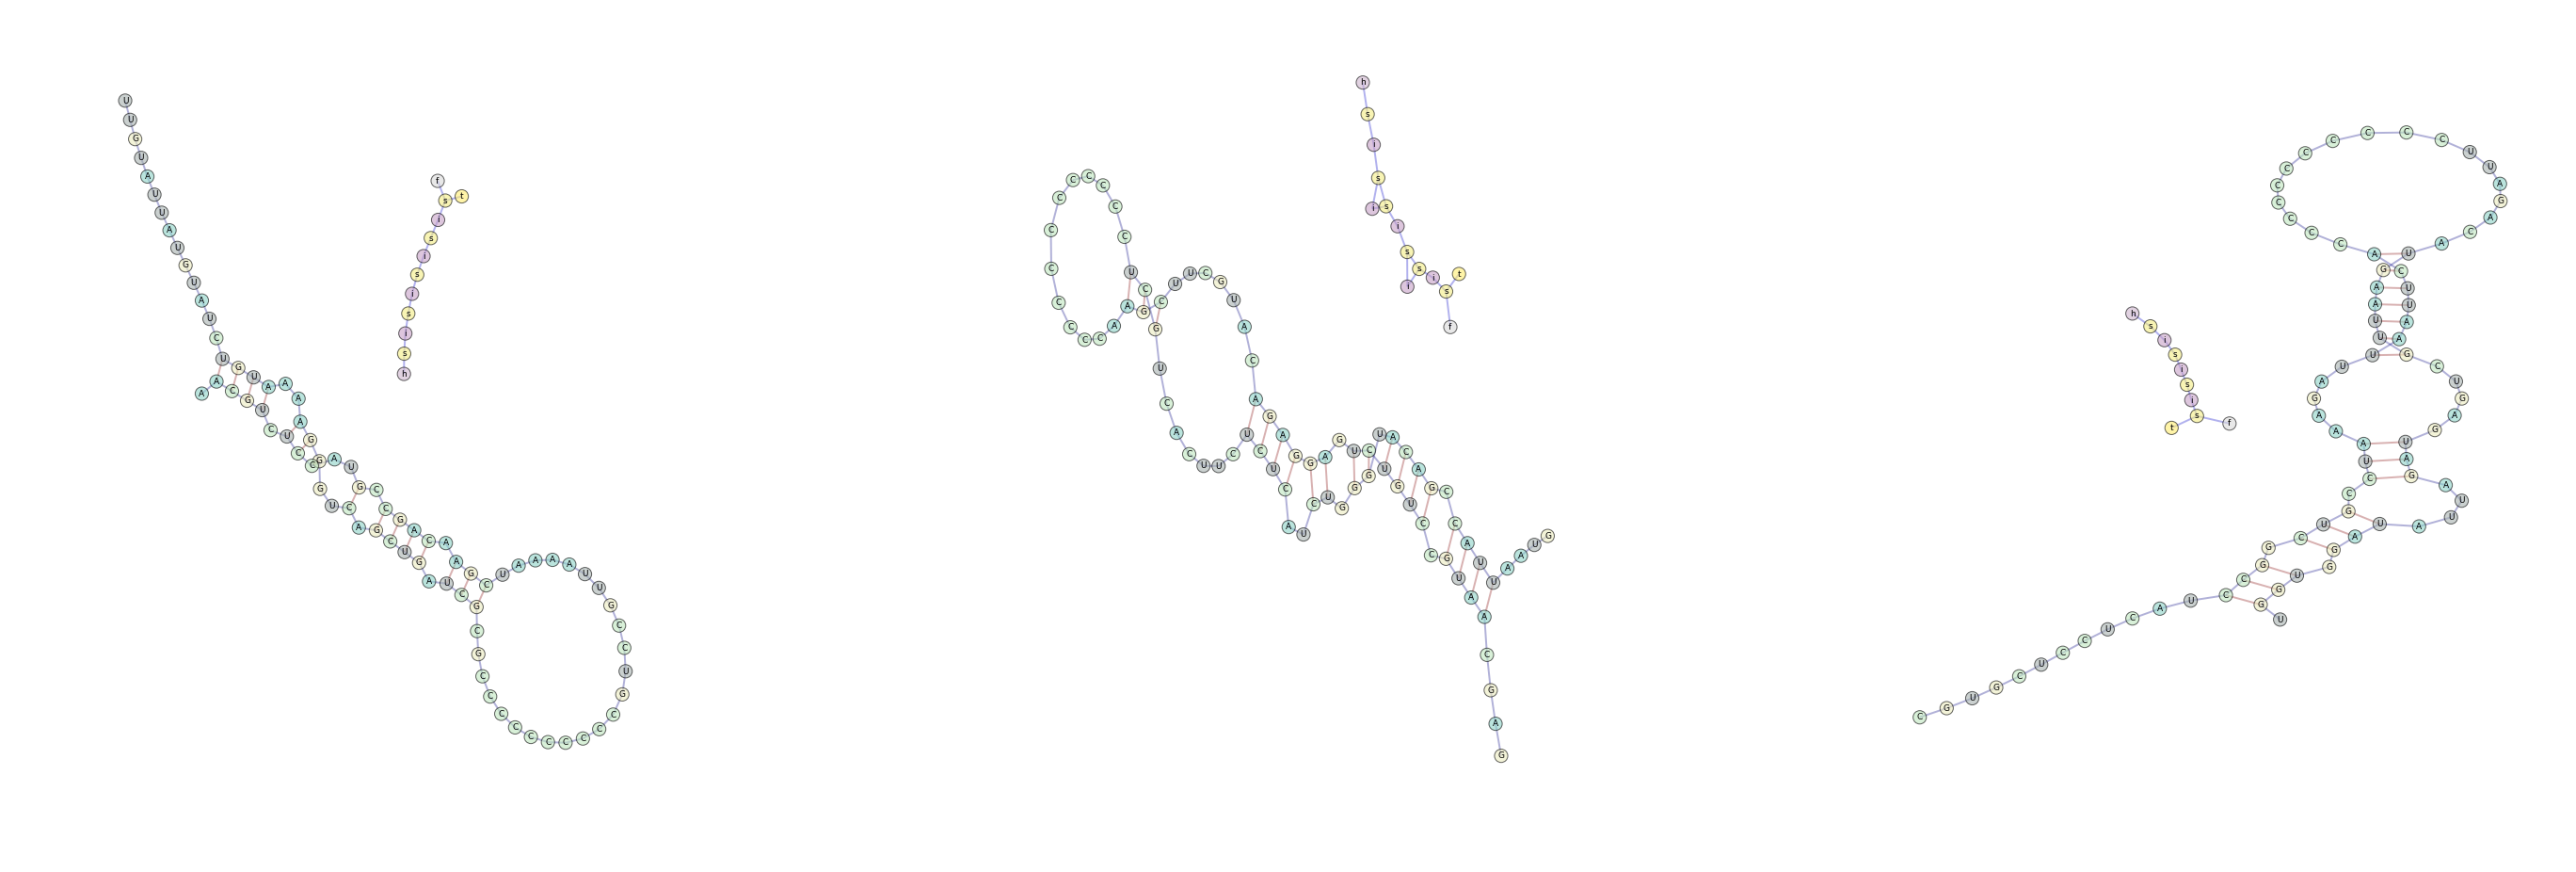

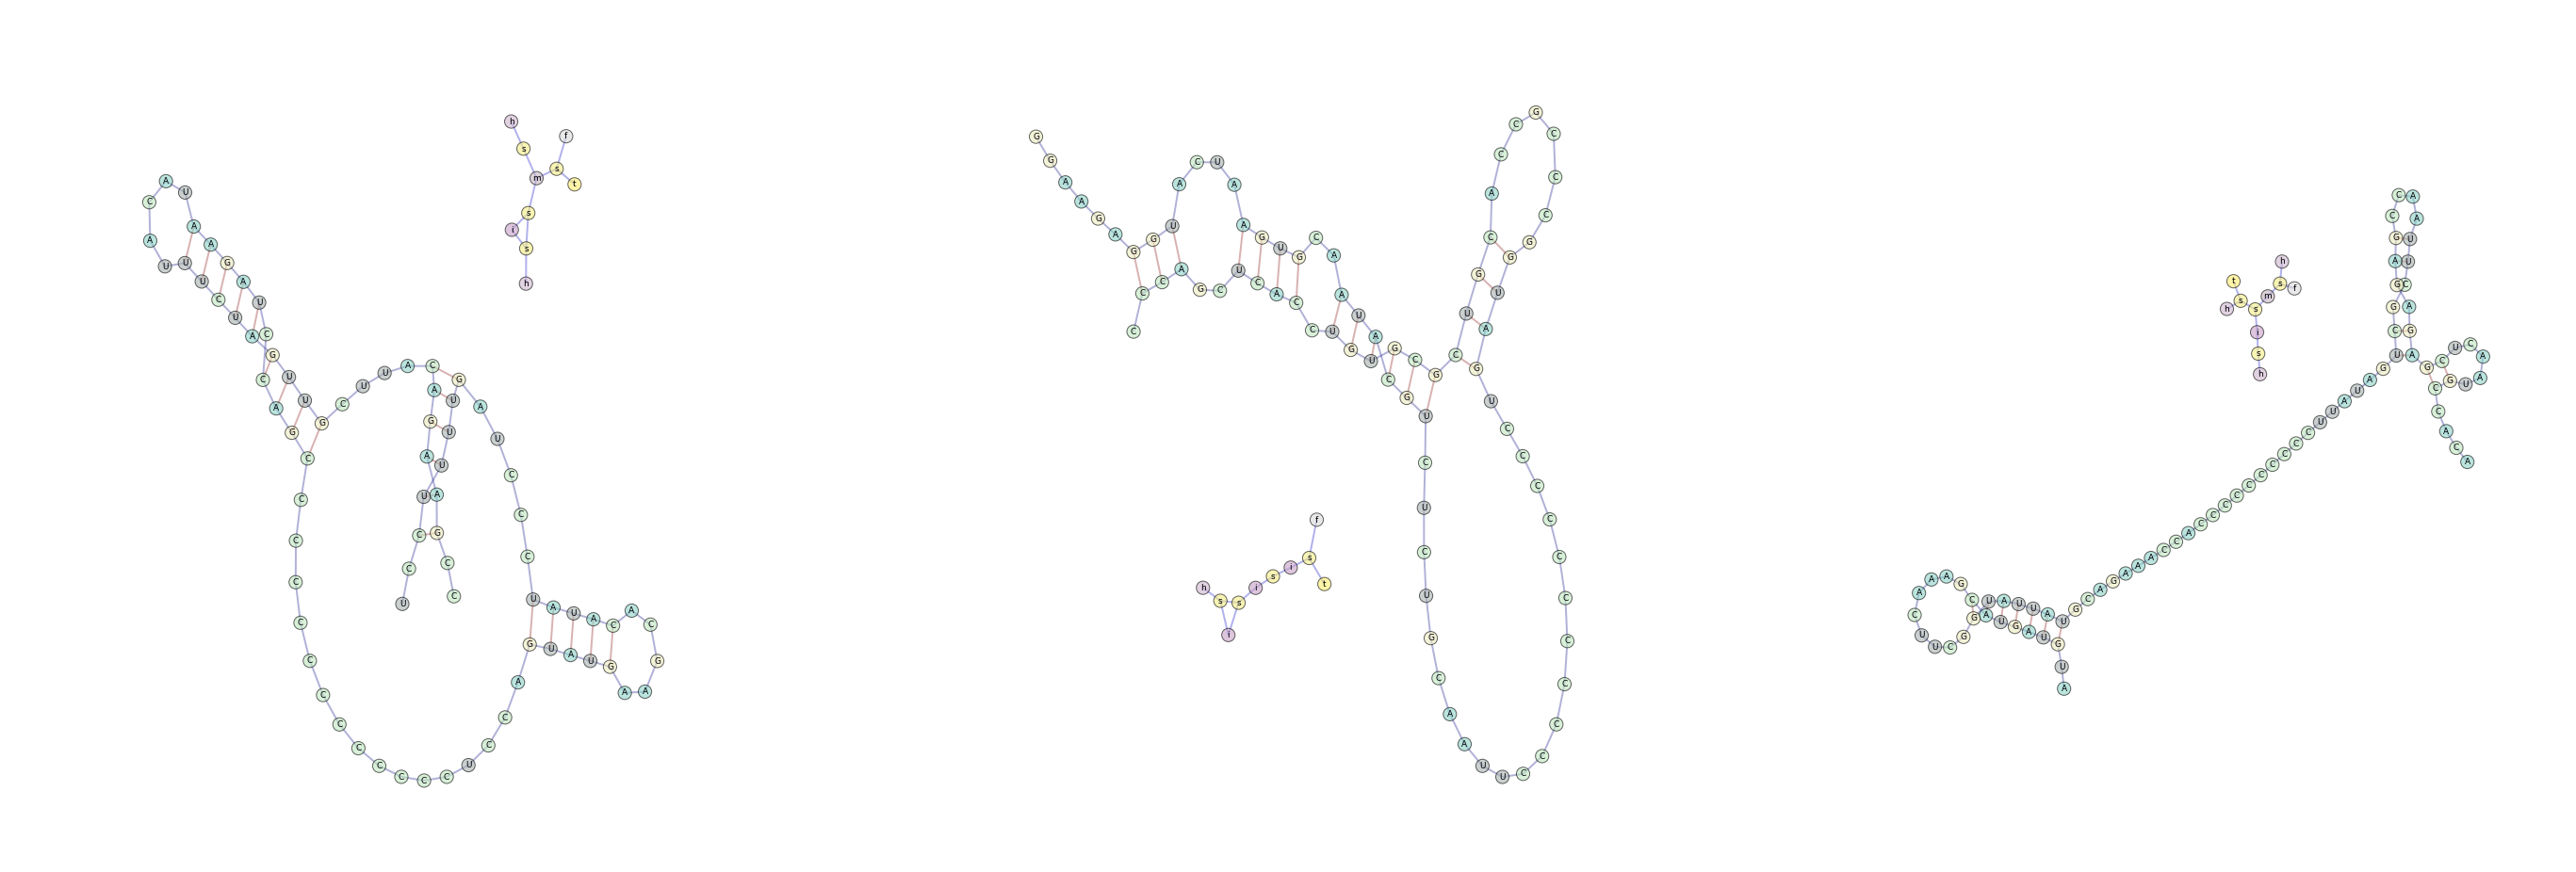

--------------------------------------------------------------------------------
cluster:19 size:6


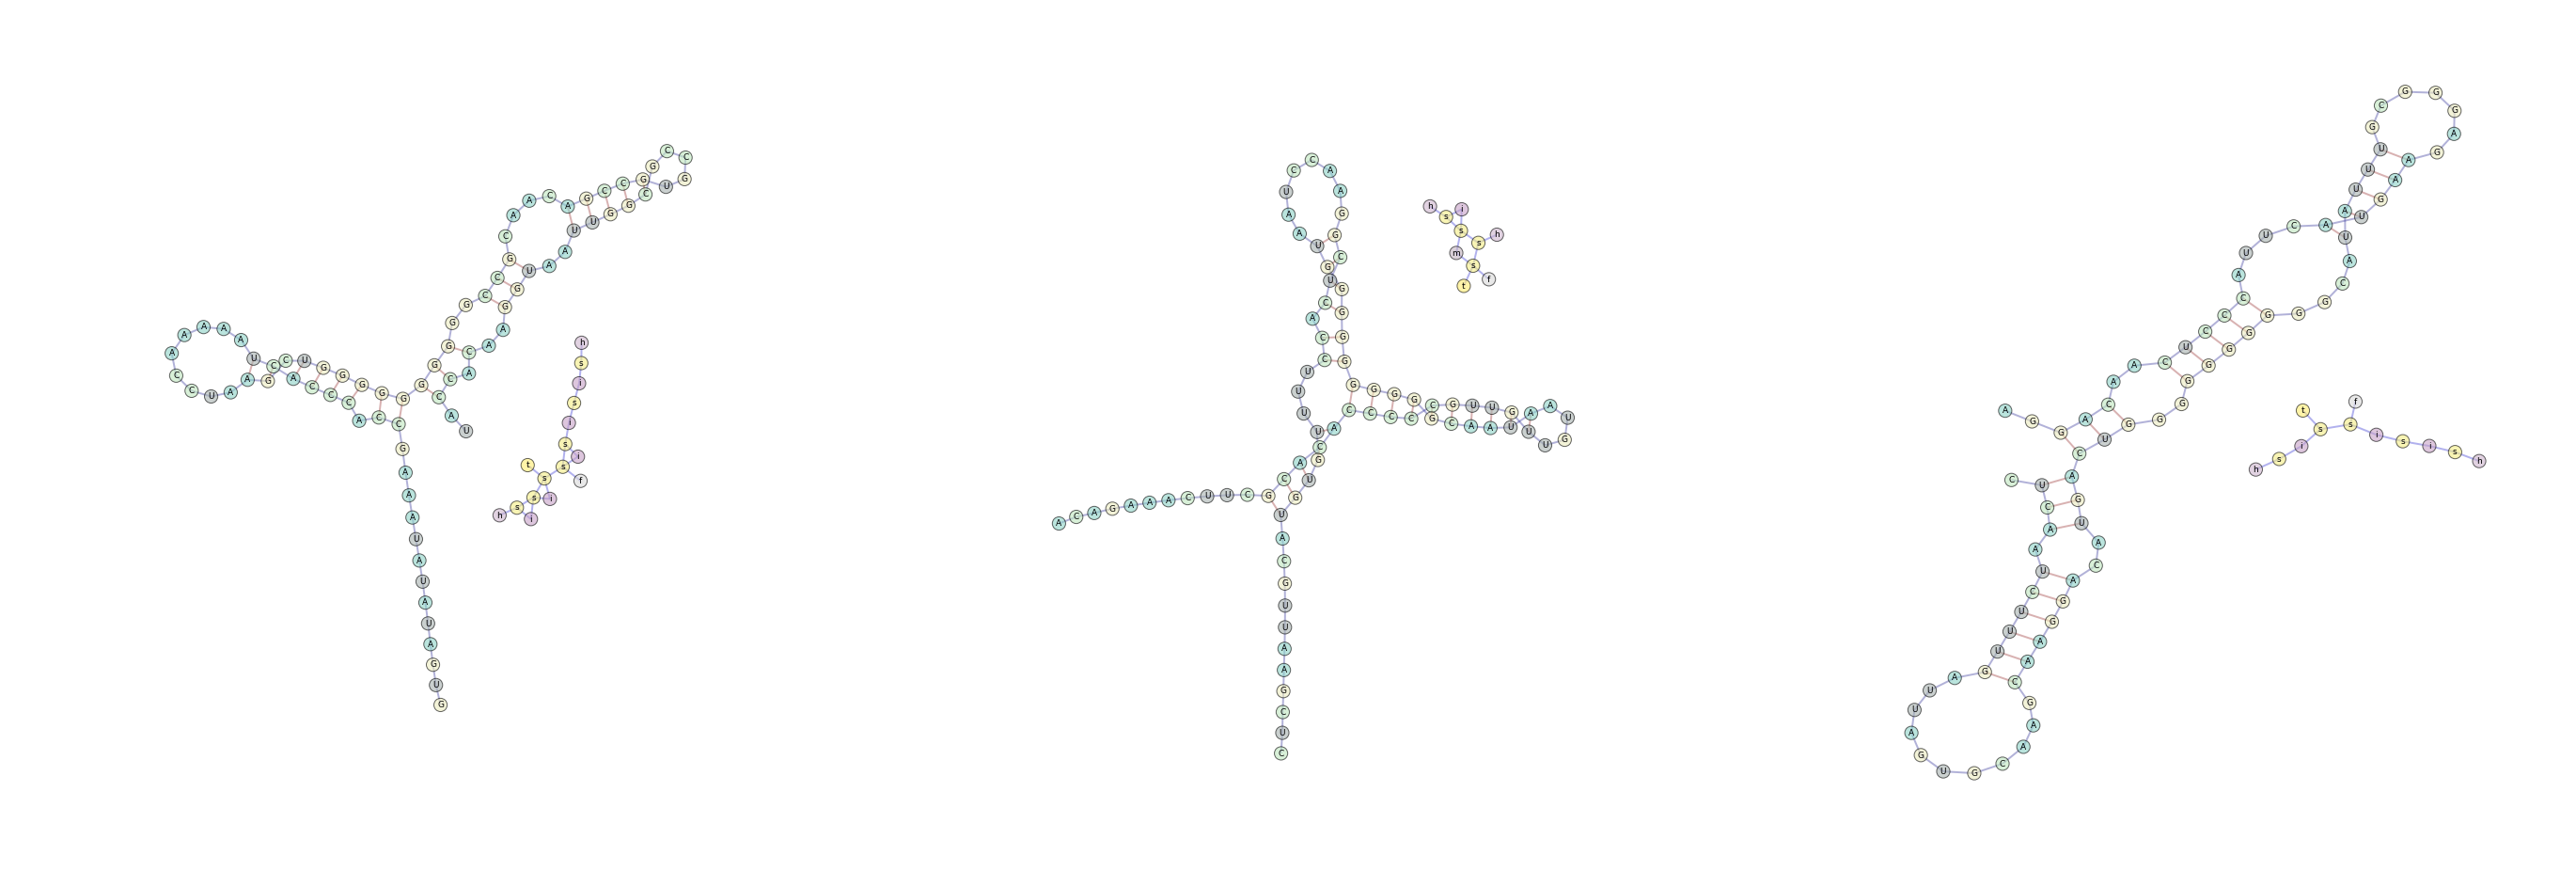

In [ ]:
from GArDen.transform import DeleteEdge
de = DeleteEdge()
n_graphs_per_line = 3
max_n_examples_drawn_per_cluster = n_graphs_per_line*3

from itertools import islice
from eden.util.display import draw_graph_set
for cluster_id in partition_list:
    clust_size = len(partition_list[cluster_id])
    if clust_size > min_clust_size and clust_size < max_clust_size:
        print '-'*80
        print 'cluster:%d size:%d' % (cluster_id, clust_size)
        clustered_graphs = islice(partition_list[cluster_id], max_n_examples_drawn_per_cluster) 
        clustered_graphs = de.transform(clustered_graphs,attribute='nesting',value=True)
        draw_graph_set(clustered_graphs, n_graphs_per_line=3, size=16, title_key='id', prog='neato', node_border=1, node_size=200, colormap='Set3',
                   edge_color='_label_',edge_alpha=.3, vertex_label='label', vertex_color='_label_', ignore_for_layout='nesting')

---